# Timeseries forecast with LSTM
**USDGBP FX rate from December 1979 to March 2018**

The code is based on:

https://mapr.com/blog/deep-learning-tensorflow/
https://github.com/lucko515/tesla-stocks-prediction/blob/master/tensorflow_lstm.ipynb

## Dependencies

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn
import time
from sklearn.preprocessing import StandardScaler

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Data preprocessing

In [2]:
usdgbp_data_new = pd.read_csv('USD_GBP Historical Data2.csv', header=0)
usdgbp_data_new['Date'] = pd.to_datetime(usdgbp_data_new['Date'])
usdgbp_data_new.head()

,Date,Price,Open,High,Low,Change %
0,1979-12-27,0.4466,0.4466,0.4466,0.4466,-0.0139
1,1979-12-28,0.4487,0.4487,0.4487,0.4487,0.0047
2,1979-12-31,0.4494,0.4494,0.4494,0.4494,0.0016
3,1980-01-02,0.4478,0.4478,0.4478,0.4478,-0.0036
4,1980-01-03,0.4457,0.4457,0.4457,0.4457,-0.0047


In [3]:
data = usdgbp_data_new['Price']
print('Total number of days in the dataset: {}'.format(len(data)))

Total number of days in the dataset: 9812


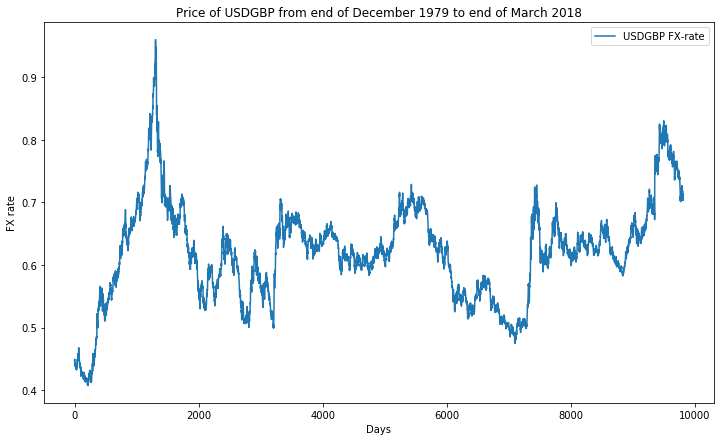

In [4]:
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Price of USDGBP from end of December 1979 to end of March 2018')
plt.xlabel('Days')
plt.ylabel('FX rate')
plt.plot(data, label='USDGBP FX-rate')
plt.legend()
plt.show()

### Train - test split

* trainset: 8844 (8833 windows), testset: 968; 

In [5]:
train_end = 8844
train, test = data[:train_end], data[train_end:]

### Scaling

In [6]:
scaler = StandardScaler()
train, test = scaler.fit_transform(train.values.reshape(-1, 1)), scaler.fit_transform(test.values.reshape(-1, 1))

In [7]:
data_new = np.concatenate((train, test), axis = 0)

### Moving Windows

In [8]:
def window_data(data, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        i += 1 
        
        
    assert len(X) ==  len(y)
    return X, y

In [9]:
window_size = 11
X_train, y_train = window_data(train, window_size)
X_test, y_test = window_data(test, window_size)

#Suitable for neural network
X_train = np.array(X_train).reshape(len(X_train), window_size, 1)
X_test = np.array(X_test).reshape(len(X_test), window_size, 1)

y_train = np.array(y_train).reshape(len(y_train), 1)
y_test = np.array(y_test).reshape(len(y_test), 1)

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (8833, 11, 1)
y_train size: (8833, 1)
X_test size: (957, 11, 1)
y_test size: (957, 1)


## Make RNN 
- hyperparameters: 
    * number of hidden layers and their size
    * batch size
    * number of epochs
- regularization: 
    * dropout wrapper (probabilistic activation on input / recurrent / output)
    * L1/L2 loss
    * gradient clipping


### LSTM cells constructor
* Can construct and initialize multiple layers of any size
* For regularization the keep rate in the dropout wrapper can be changed both for input and output

In [10]:
def LSTM_cell(hidden_layer_size, batch_size, number_of_layers, dropout_rate_out = 1, dropout_rate_in = 1, dropout=True):
    
    layers = []
    i = 0
    while(i < number_of_layers):
        layers.append(tf.contrib.rnn.BasicLSTMCell(hidden_layer_size))
        if dropout:
            layers[i] = tf.contrib.rnn.DropoutWrapper(layers[i], 
                                                      output_keep_prob=dropout_rate_out, 
                                                      input_keep_prob=dropout_rate_in)
        i += 1
        
    cell = tf.contrib.rnn.MultiRNNCell(layers)
    
    init_state = cell.zero_state(batch_size, tf.float32)
    
    return cell, init_state

### Output layer; Losses and Optimizer

In [11]:
def outputlayer_opt_loss(lstm_output, in_size, out_size, targets, learning_rate, grad_clip_margin, l1_l, l2_l, l1l2_l1, l1l2_l2, reg_type = 'no_penalty'):
    
    #Regularization
        #if error
    reg_types = ['no_penalty', 'L1', 'L2', 'L1L2']
    if reg_type not in reg_types:
        raise ValueError("Invalid reg type. Expected one of: %s" % reg_types)
    
        #define regularization type
    if reg_type == 'L1':
        regularizer = tf.contrib.layers.l1_regularizer(scale = l1_l)
    elif reg_type == 'L2':
        regularizer = tf.contrib.layers.l2_regularizer(scale = l2_l)
    elif reg_type == 'L1L2':
        regularizer = tf.contrib.layers.l1_l2_regularizer(scale_l1 = l1l2_l1, scale_l2 = l1l2_l2)
    
    
    #Output layer construction
    x = lstm_output[:, -1, :]
    print(x)
    weights = tf.Variable(tf.truncated_normal([in_size, out_size], stddev=0.05), 
                          name='output_layer_weights') 
    if reg_type != 'no_penalty':
        tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, weights) #for regularization
    
    bias = tf.Variable(tf.zeros([out_size]), name='output_layer_bias')
    
    output = tf.matmul(x, weights) + bias #output
    
    #Define losses
    losses = []
    for i in range(targets.get_shape()[0]):
        losses.append([(tf.pow(output[i] - targets[i], 2))])
    
    #Adjust according to regularization type
    if reg_type == 'no_penalty':   
        loss = tf.reduce_mean(losses)
    else:
        reg_variables = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        reg_term = tf.contrib.layers.apply_regularization(regularizer, reg_variables)
        loss = tf.reduce_mean(losses) + reg_term
    
    #Clipping the gradient loss
    gradients = tf.gradients(loss, tf.trainable_variables())
    clipper_, _ = tf.clip_by_global_norm(gradients, grad_clip_margin)
    
    #Optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))
    
    return output, loss, train_optimizer

### Save Output

In [12]:
from IPython.display import display,Javascript 
def save_notebook():
    return display(Javascript("IPython.notebook.save_notebook()"),
                   include=['application/javascript'])

def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

### Multiple types of hyperparameters and regularization methods for crossvalidation

The parameters can be changed according to what settings are requested.

In [13]:
#Hyperparameters
hidden_num = [1, 1, 2, 4]
hidden_size = [8, 16, 16, 48]
batch_size = 11
epoch = [800, 800, 800, 1500]

#Regularization
out_keep = [1, 1, 1, 1, 1, 1]
in_keep = [1, 1, 1, 1, 1, 1]
regs = ['L1', 'L1','L2', 'L2', 'L1L2', 'L1L2']
l1_lambdas = [0.001, 0.002, 0, 0, 0.0005, 0.0008]
l2_lambdas = [0, 0, 0.001, 0.002, 0.0005, 0.0008]
gradient_clip_mrg = 4 #To prevent exploding gradient, we use clipper to clip gradients below -margin or above this margin

The below loops can be changed according to what combinations we wish to explore. 

* **First**: the outer loop were the number of layers, the inner loop was the layer size (Model ID and initializer need to be adjusted accordingly)
* **Second**:, the outer layer ran through the 4 different models - chosen from the first run - the inner layer runs on the different dropouts (dropout to be modified above)
* **Third**: same as second, except for the regularization changing to weight penalty

Model  NL1_SL8_DRI1_PL2_L1Lam0_L2Lam0.001_EP800  starts running.
Tensor("strided_slice:0", shape=(11, 8), dtype=float32)
Epoch 0/800  Current loss: 0.5753046274185181
Epoch 50/800  Current loss: 0.005933737847954035
Epoch 100/800  Current loss: 0.005177197512239218
Epoch 150/800  Current loss: 0.004854103084653616
Epoch 200/800  Current loss: 0.004773647524416447
Epoch 250/800  Current loss: 0.0046495539136230946
Epoch 300/800  Current loss: 0.004501113668084145
Epoch 350/800  Current loss: 0.004564115311950445
Epoch 400/800  Current loss: 0.0045215170830488205
Epoch 450/800  Current loss: 0.004318936262279749
Epoch 500/800  Current loss: 0.004289030097424984
Epoch 550/800  Current loss: 0.00431737070903182
Epoch 600/800  Current loss: 0.004331734962761402
Epoch 650/800  Current loss: 0.0042200274765491486
Epoch 700/800  Current loss: 0.0041436064057052135
Epoch 750/800  Current loss: 0.0041804080829024315
Training ran for:  0.6786014076073964  hours. ModelID:  NL1_SL8_DRI1_PL2_L1Lam0_

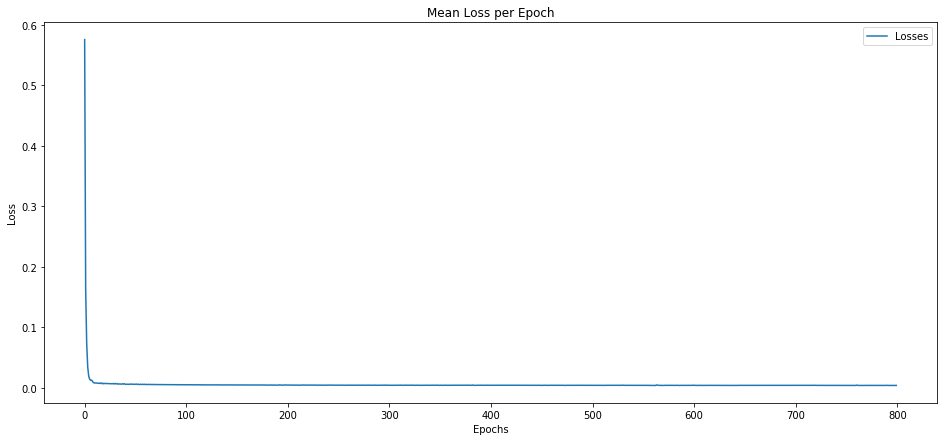

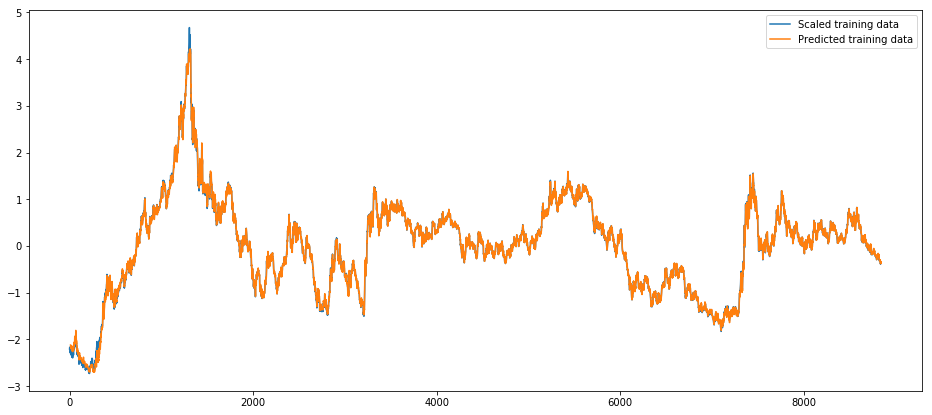

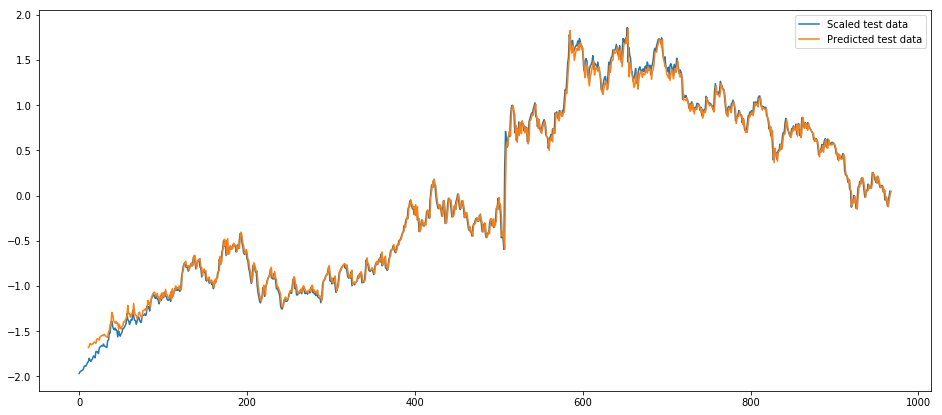

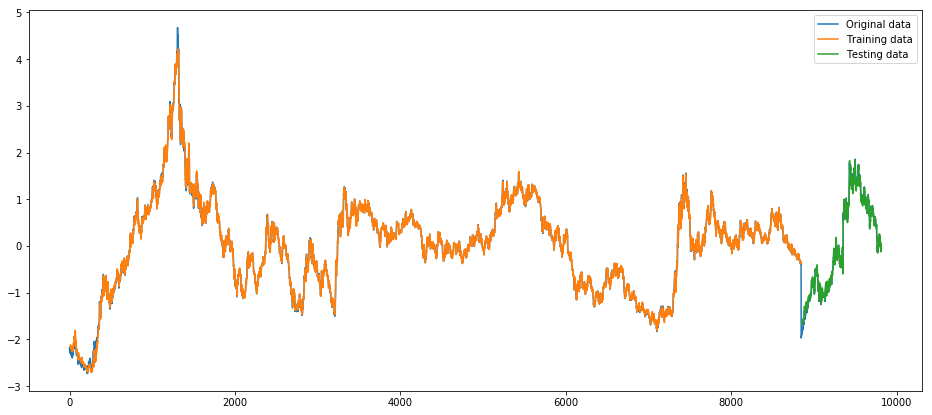

The training error is:  [0.00316123] . The testing error is:  [0.00643126] .
Model  NL1_SL8_DRI1_PL2_L1Lam0_L2Lam0.002_EP800  starts running.
Tensor("strided_slice:0", shape=(11, 8), dtype=float32)
Epoch 0/800  Current loss: 0.6490049958229065
Epoch 50/800  Current loss: 0.0074712615460157394
Epoch 100/800  Current loss: 0.006556577980518341
Epoch 150/800  Current loss: 0.00622236542403698
Epoch 200/800  Current loss: 0.006180068012326956
Epoch 250/800  Current loss: 0.005825475789606571
Epoch 300/800  Current loss: 0.00607255706563592
Epoch 350/800  Current loss: 0.005879863165318966
Epoch 400/800  Current loss: 0.005620507523417473
Epoch 450/800  Current loss: 0.005674198269844055
Epoch 500/800  Current loss: 0.0055434261448681355
Epoch 550/800  Current loss: 0.005554802715778351
Epoch 600/800  Current loss: 0.005422127898782492
Epoch 650/800  Current loss: 0.005439849570393562
Epoch 700/800  Current loss: 0.00542822852730751
Epoch 750/800  Current loss: 0.0053594037890434265
Trainin

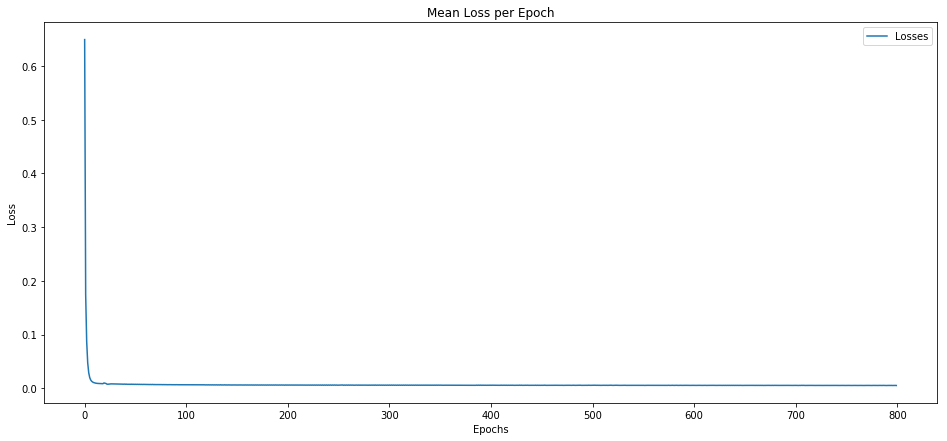

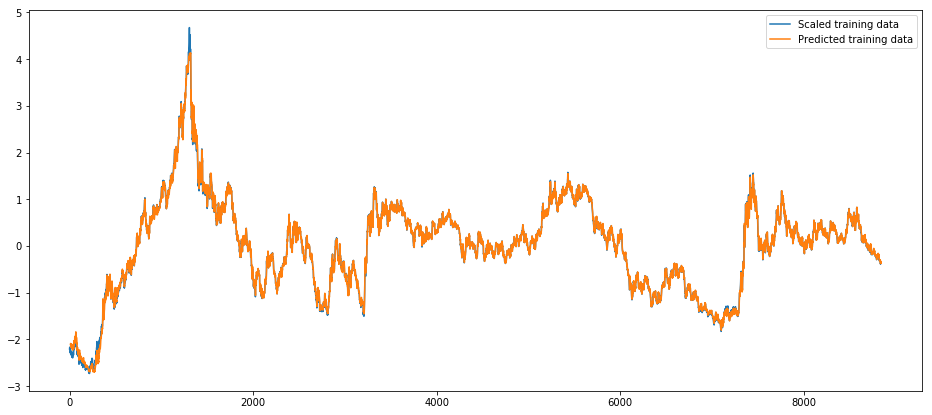

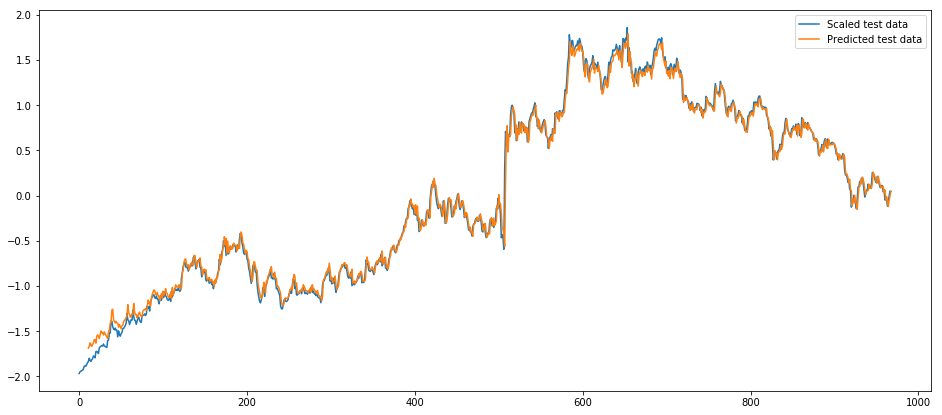

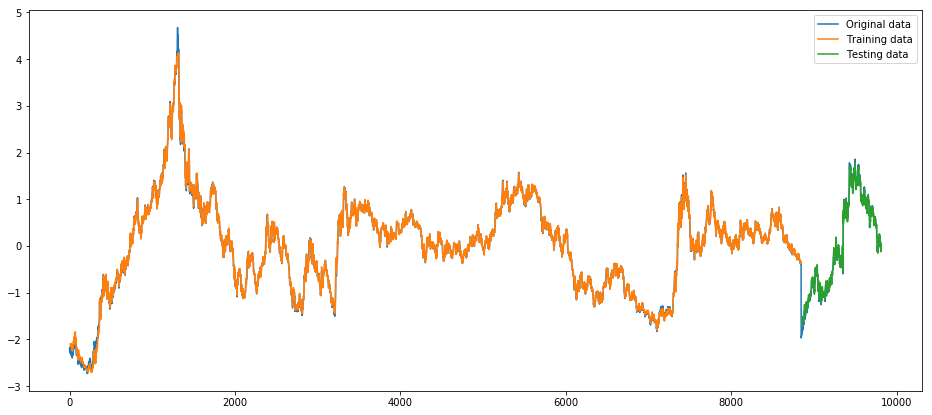

The training error is:  [0.0034787] . The testing error is:  [0.00662161] .
Model  NL1_SL8_DRI1_PL1L2_L1Lam0.0005_L2Lam0.0005_EP800  starts running.
Tensor("strided_slice:0", shape=(11, 8), dtype=float32)
Epoch 0/800  Current loss: 0.6093924641609192
Epoch 50/800  Current loss: 0.0073104300536215305
Epoch 100/800  Current loss: 0.006639101542532444
Epoch 150/800  Current loss: 0.006249075289815664
Epoch 200/800  Current loss: 0.0061006564646959305
Epoch 250/800  Current loss: 0.0059836246073246
Epoch 300/800  Current loss: 0.00592941977083683
Epoch 350/800  Current loss: 0.005889210384339094
Epoch 400/800  Current loss: 0.005798805970698595
Epoch 450/800  Current loss: 0.0057009379379451275
Epoch 500/800  Current loss: 0.005639370996505022
Epoch 550/800  Current loss: 0.005700788460671902
Epoch 600/800  Current loss: 0.005695343017578125
Epoch 650/800  Current loss: 0.00561571167781949
Epoch 700/800  Current loss: 0.005509515292942524
Epoch 750/800  Current loss: 0.0055569992400705814


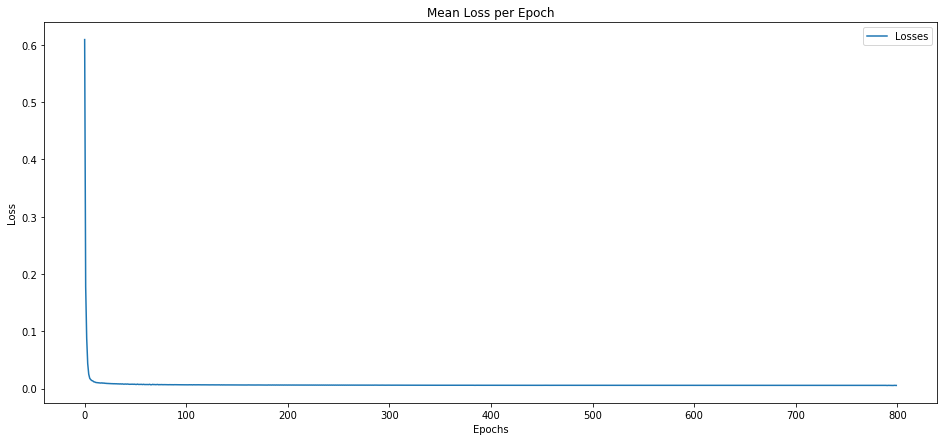

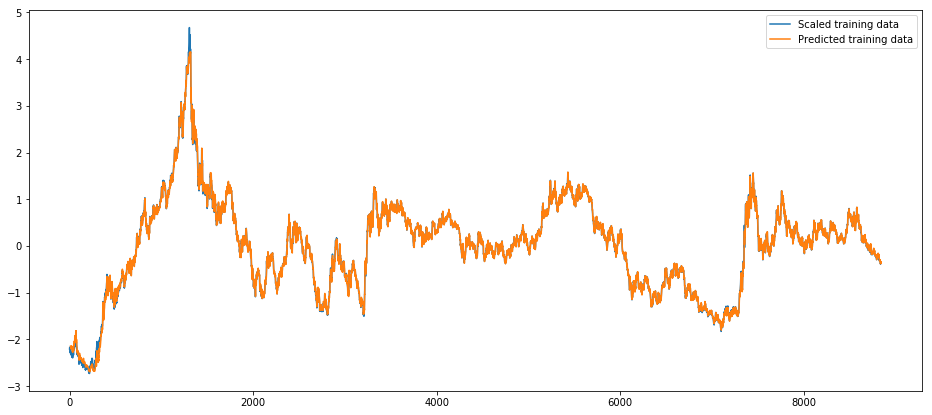

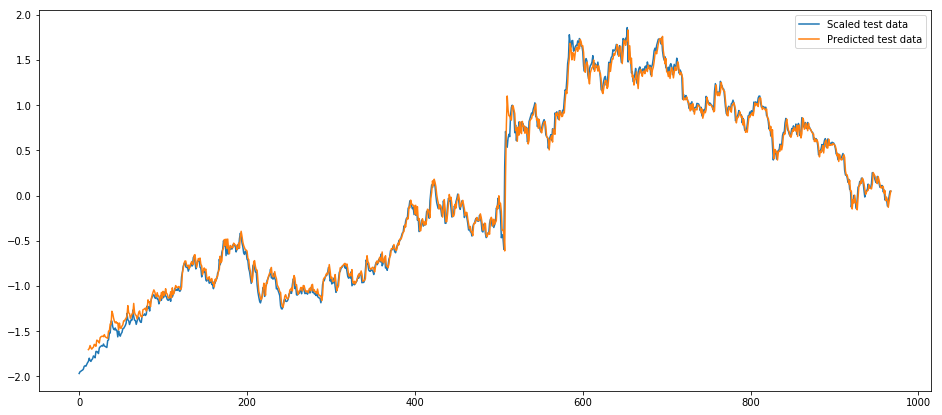

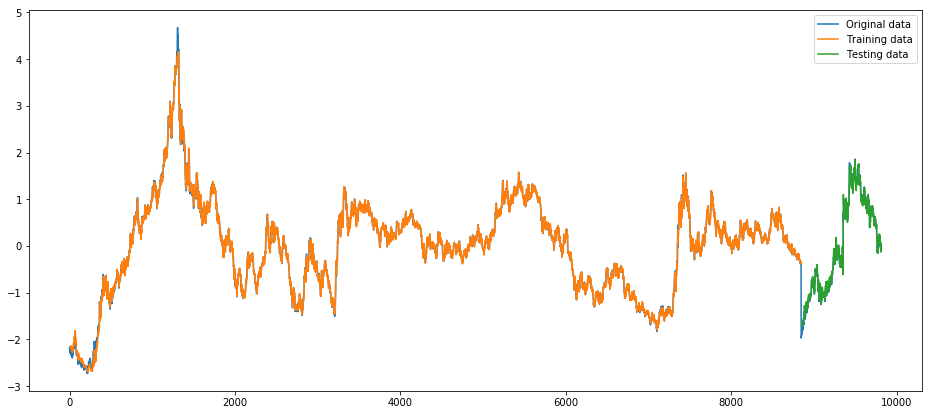

The training error is:  [0.00317563] . The testing error is:  [0.00677449] .
Model  NL1_SL8_DRI1_PL1L2_L1Lam0.0008_L2Lam0.0008_EP800  starts running.
Tensor("strided_slice:0", shape=(11, 8), dtype=float32)
Epoch 0/800  Current loss: 0.6441025733947754
Epoch 50/800  Current loss: 0.009210736490786076
Epoch 100/800  Current loss: 0.007999041117727757
Epoch 150/800  Current loss: 0.007781892083585262
Epoch 200/800  Current loss: 0.007508918177336454
Epoch 250/800  Current loss: 0.00740560470148921
Epoch 300/800  Current loss: 0.007317672483623028
Epoch 350/800  Current loss: 0.007242437917739153
Epoch 400/800  Current loss: 0.0072130379267036915
Epoch 450/800  Current loss: 0.007197384722530842
Epoch 500/800  Current loss: 0.007087972480803728
Epoch 550/800  Current loss: 0.007087194360792637
Epoch 600/800  Current loss: 0.007098391652107239
Epoch 650/800  Current loss: 0.006993243936449289
Epoch 700/800  Current loss: 0.006863115355372429
Epoch 750/800  Current loss: 0.006946707610040903

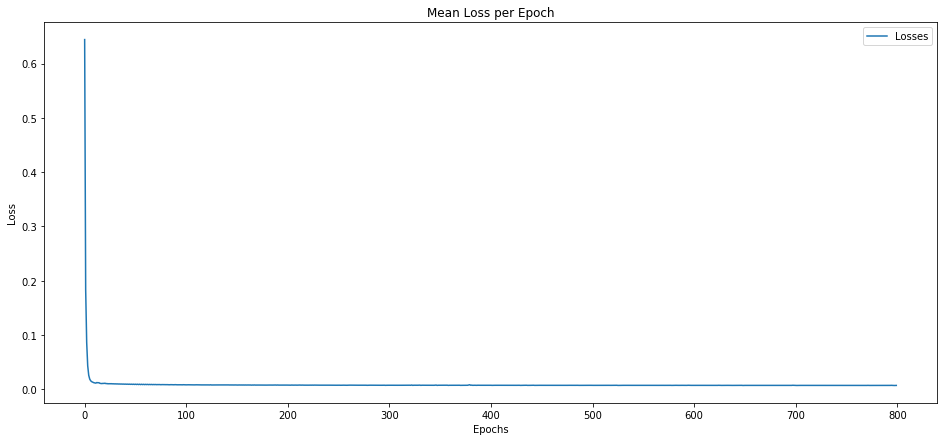

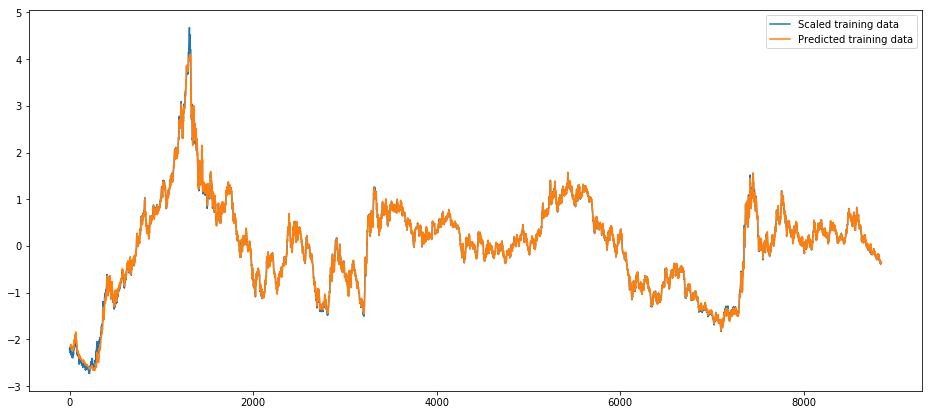

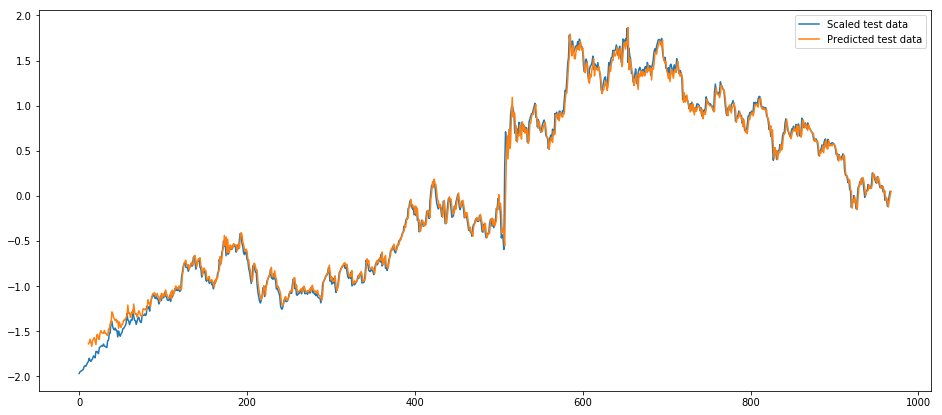

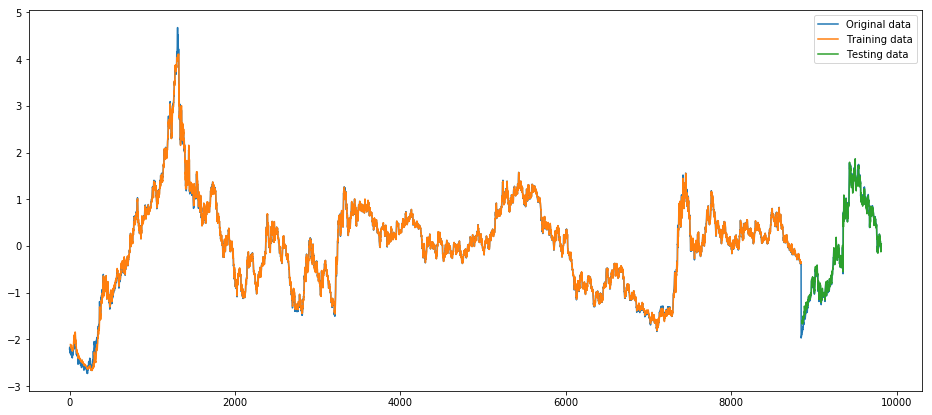

The training error is:  [0.00346857] . The testing error is:  [0.0070811] .
Model  NL1_SL16_DRI1_PL2_L1Lam0_L2Lam0.001_EP800  starts running.
Tensor("strided_slice:0", shape=(11, 16), dtype=float32)
Epoch 0/800  Current loss: 0.4497765898704529
Epoch 50/800  Current loss: 0.006391001399606466
Epoch 100/800  Current loss: 0.0059965080581605434
Epoch 150/800  Current loss: 0.005478507839143276
Epoch 200/800  Current loss: 0.004848838783800602
Epoch 250/800  Current loss: 0.004793696571141481
Epoch 300/800  Current loss: 0.004312754143029451
Epoch 350/800  Current loss: 0.0040739732794463634
Epoch 400/800  Current loss: 0.003983201924711466
Epoch 450/800  Current loss: 0.0040024518966674805
Epoch 500/800  Current loss: 0.003856264753267169
Epoch 550/800  Current loss: 0.0038457477930933237
Epoch 600/800  Current loss: 0.0038572626654058695
Epoch 650/800  Current loss: 0.003984168637543917
Epoch 700/800  Current loss: 0.00393872894346714
Epoch 750/800  Current loss: 0.0036590686067938805
T

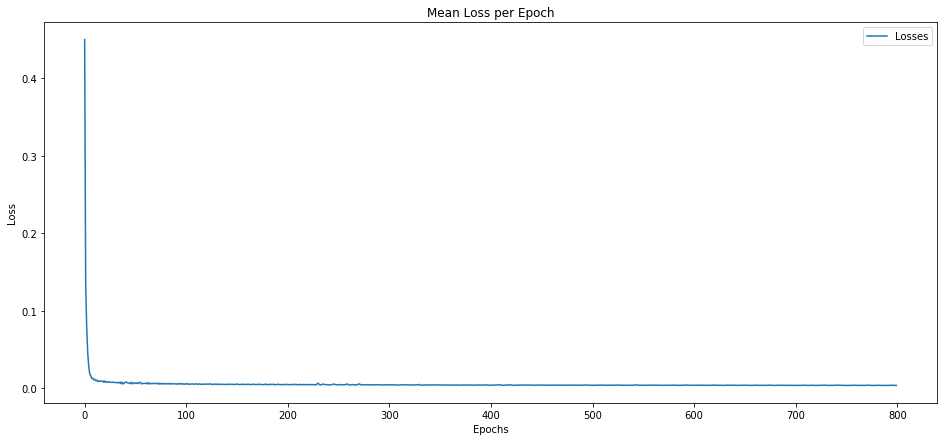

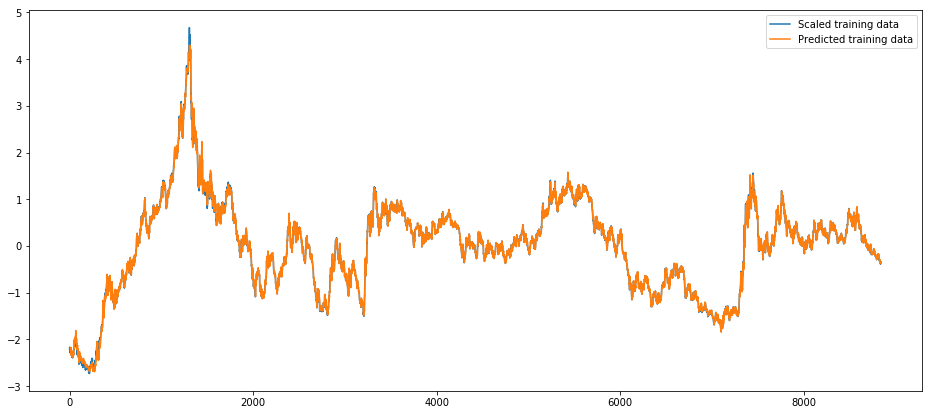

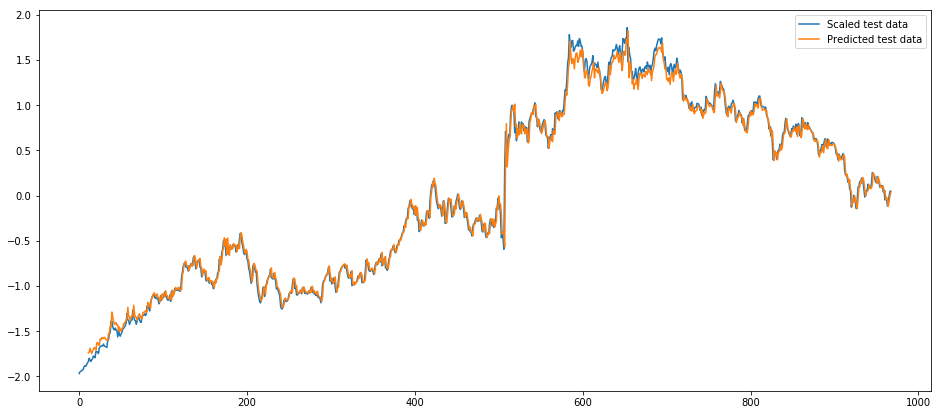

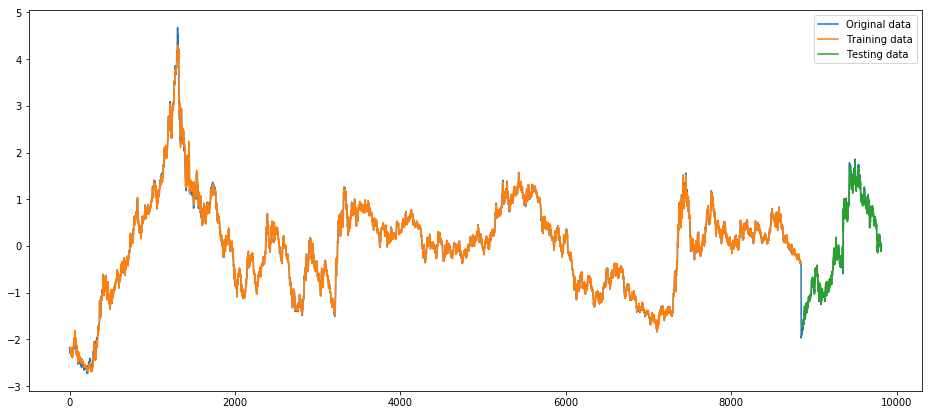

The training error is:  [0.00285778] . The testing error is:  [0.00663612] .
Model  NL1_SL16_DRI1_PL2_L1Lam0_L2Lam0.002_EP800  starts running.
Tensor("strided_slice:0", shape=(11, 16), dtype=float32)
Epoch 0/800  Current loss: 0.4596177339553833
Epoch 50/800  Current loss: 0.0069532631896436214
Epoch 100/800  Current loss: 0.0057415128685534
Epoch 150/800  Current loss: 0.005193908698856831
Epoch 200/800  Current loss: 0.005115226376801729
Epoch 250/800  Current loss: 0.004996371455490589
Epoch 300/800  Current loss: 0.004844242241233587
Epoch 350/800  Current loss: 0.004733129404485226
Epoch 400/800  Current loss: 0.004643393214792013
Epoch 450/800  Current loss: 0.004638971295207739
Epoch 500/800  Current loss: 0.004637041129171848
Epoch 550/800  Current loss: 0.004464305471628904
Epoch 600/800  Current loss: 0.0044940621592104435
Epoch 650/800  Current loss: 0.004436540883034468
Epoch 700/800  Current loss: 0.00427761347964406
Epoch 750/800  Current loss: 0.004296943079680204
Traini

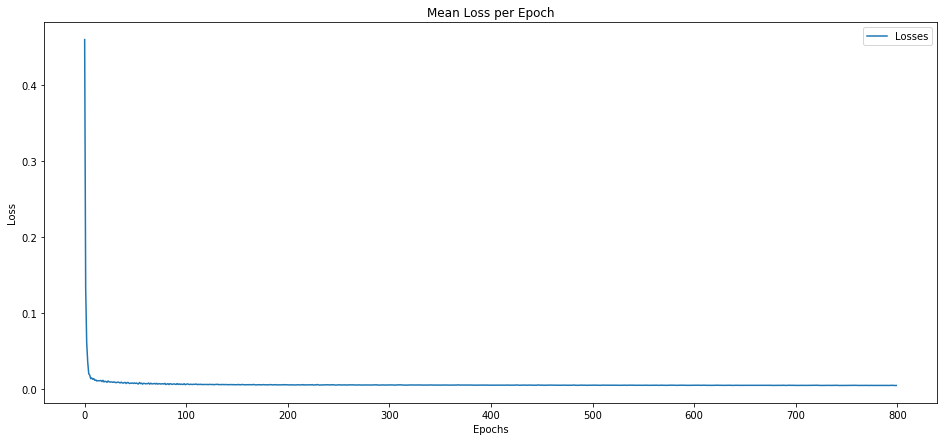

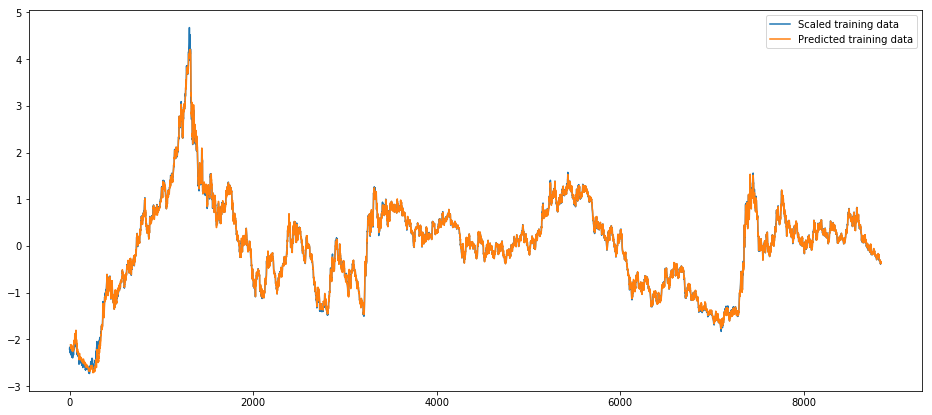

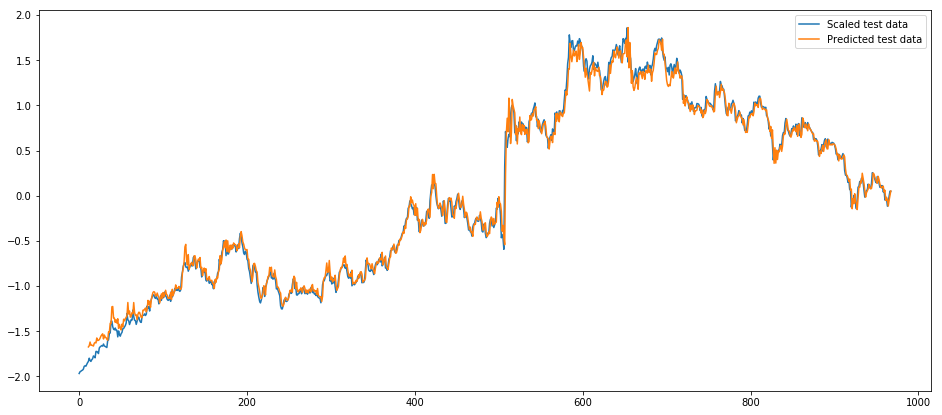

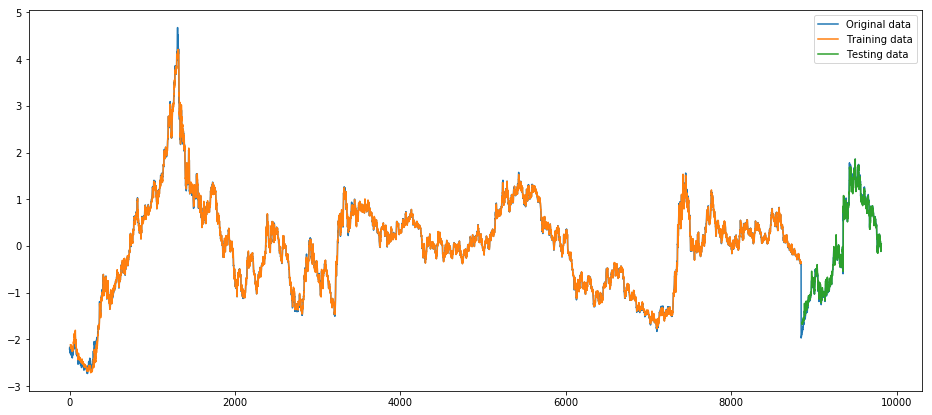

The training error is:  [0.00286744] . The testing error is:  [0.00783874] .
Model  NL1_SL16_DRI1_PL1L2_L1Lam0.0005_L2Lam0.0005_EP800  starts running.
Tensor("strided_slice:0", shape=(11, 16), dtype=float32)
Epoch 0/800  Current loss: 0.4428439140319824
Epoch 50/800  Current loss: 0.007335884962230921
Epoch 100/800  Current loss: 0.00776721490547061
Epoch 150/800  Current loss: 0.0065353442914783955
Epoch 200/800  Current loss: 0.006208759266883135
Epoch 250/800  Current loss: 0.006154587026685476
Epoch 300/800  Current loss: 0.00590153131633997
Epoch 350/800  Current loss: 0.005623051431030035
Epoch 400/800  Current loss: 0.005529619287699461
Epoch 450/800  Current loss: 0.005369929131120443
Epoch 500/800  Current loss: 0.005444752983748913
Epoch 550/800  Current loss: 0.005639638751745224
Epoch 600/800  Current loss: 0.005465932656079531
Epoch 650/800  Current loss: 0.005518452264368534
Epoch 700/800  Current loss: 0.005305336322635412
Epoch 750/800  Current loss: 0.00519639719277620

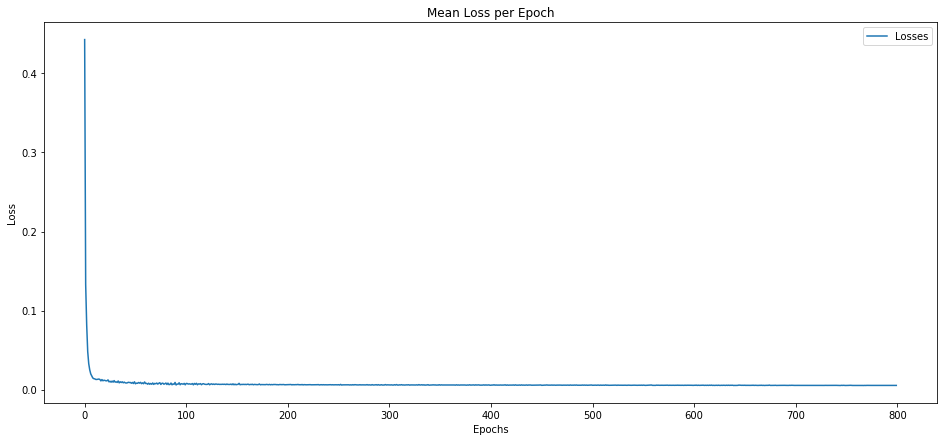

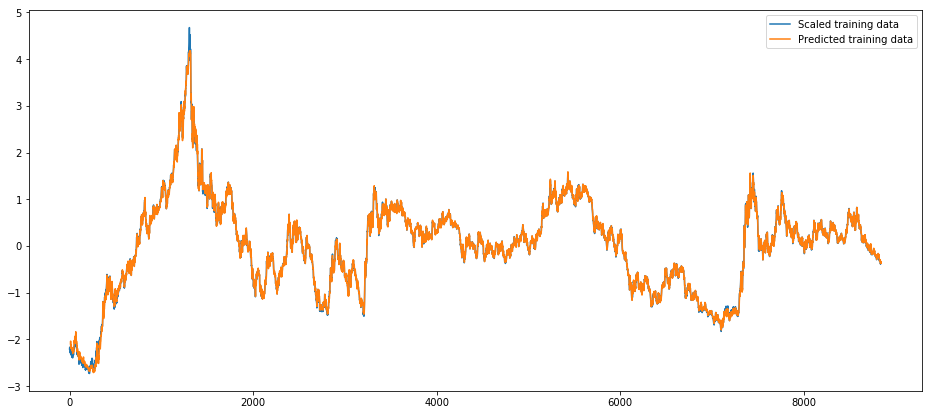

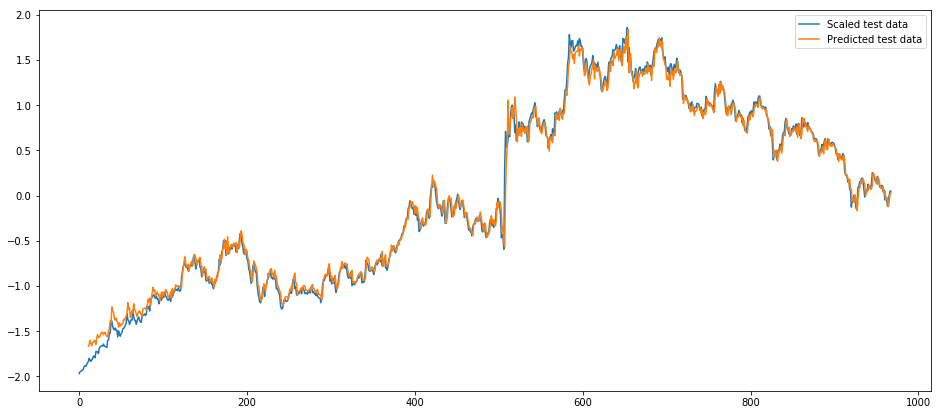

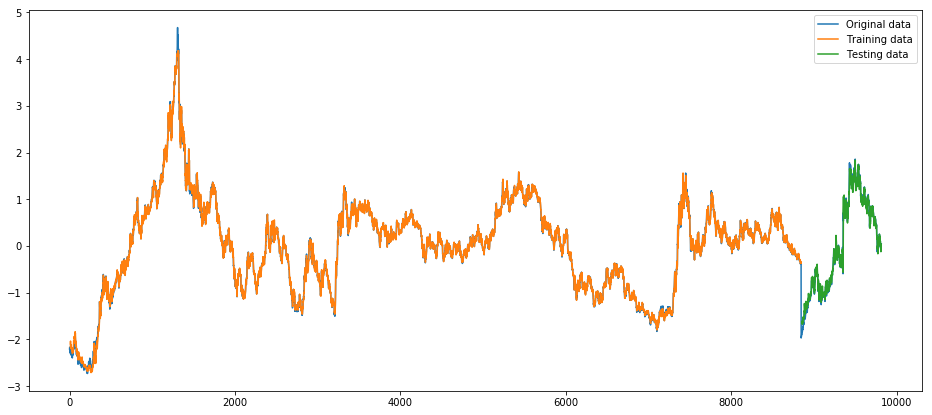

The training error is:  [0.00284314] . The testing error is:  [0.0077827] .
Model  NL1_SL16_DRI1_PL1L2_L1Lam0.0008_L2Lam0.0008_EP800  starts running.
Tensor("strided_slice:0", shape=(11, 16), dtype=float32)
Epoch 0/800  Current loss: 0.4095655083656311
Epoch 50/800  Current loss: 0.010560008697211742
Epoch 100/800  Current loss: 0.008772749453783035
Epoch 150/800  Current loss: 0.008864245377480984
Epoch 200/800  Current loss: 0.007914384827017784
Epoch 250/800  Current loss: 0.00748492730781436
Epoch 300/800  Current loss: 0.007276653777807951
Epoch 350/800  Current loss: 0.00743691623210907
Epoch 400/800  Current loss: 0.007096232380717993
Epoch 450/800  Current loss: 0.007433061022311449
Epoch 500/800  Current loss: 0.0071287499740719795
Epoch 550/800  Current loss: 0.007368959952145815
Epoch 600/800  Current loss: 0.007222023792564869
Epoch 650/800  Current loss: 0.007101275026798248
Epoch 700/800  Current loss: 0.0068610310554504395
Epoch 750/800  Current loss: 0.00687196152284741

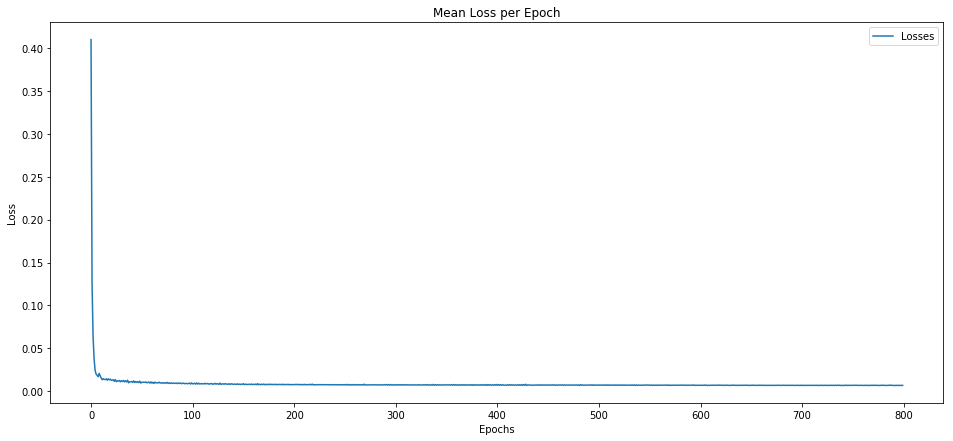

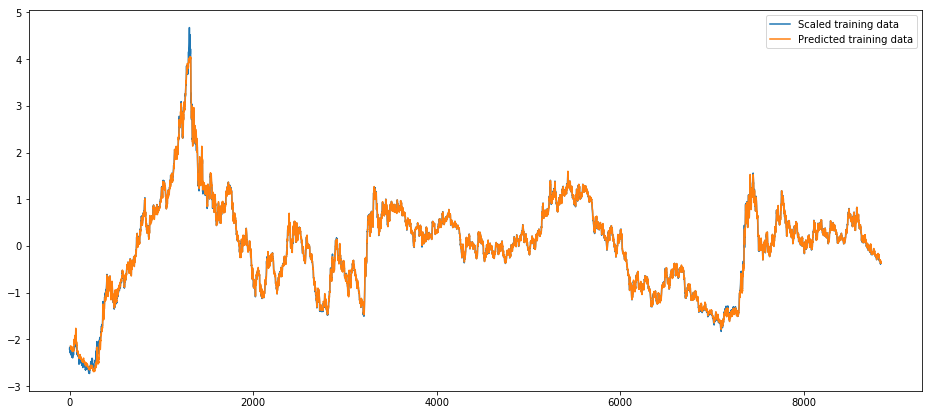

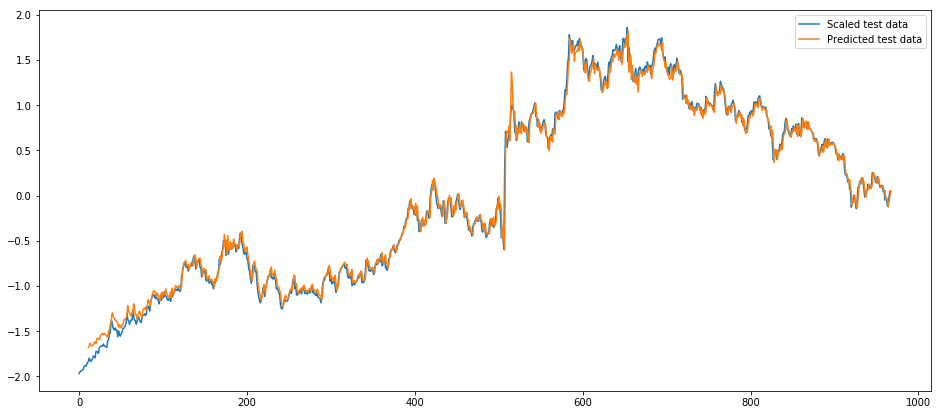

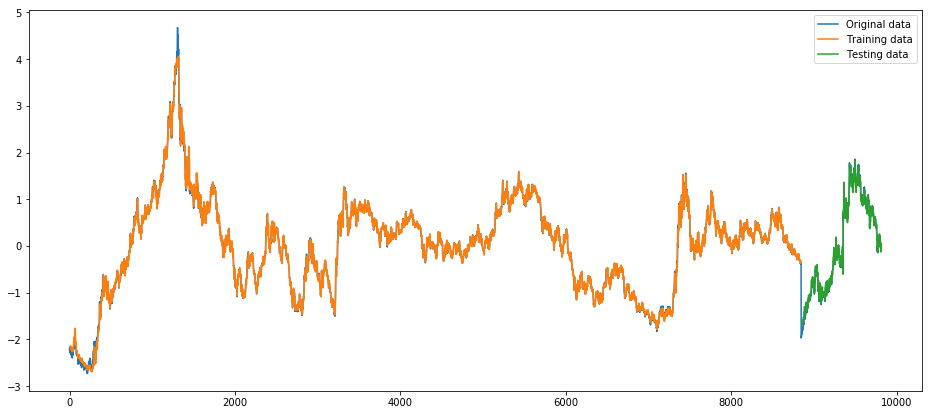

The training error is:  [0.00318214] . The testing error is:  [0.00664738] .
Model  NL2_SL16_DRI1_PL2_L1Lam0_L2Lam0.001_EP800  starts running.
Tensor("strided_slice:0", shape=(11, 16), dtype=float32)
Epoch 0/800  Current loss: 0.44338974356651306
Epoch 50/800  Current loss: 0.012819742783904076
Epoch 100/800  Current loss: 0.008215383626520634
Epoch 150/800  Current loss: 0.0066392566077411175
Epoch 200/800  Current loss: 0.0051468913443386555
Epoch 250/800  Current loss: 0.005082339979708195
Epoch 300/800  Current loss: 0.005357035435736179
Epoch 350/800  Current loss: 0.004232344217598438
Epoch 400/800  Current loss: 0.004538275301456451
Epoch 450/800  Current loss: 0.004141300916671753
Epoch 500/800  Current loss: 0.004985902924090624
Epoch 550/800  Current loss: 0.004117255099117756
Epoch 600/800  Current loss: 0.004286035429686308
Epoch 650/800  Current loss: 0.0038254554383456707
Epoch 700/800  Current loss: 0.003833156079053879
Epoch 750/800  Current loss: 0.0038268817588686943


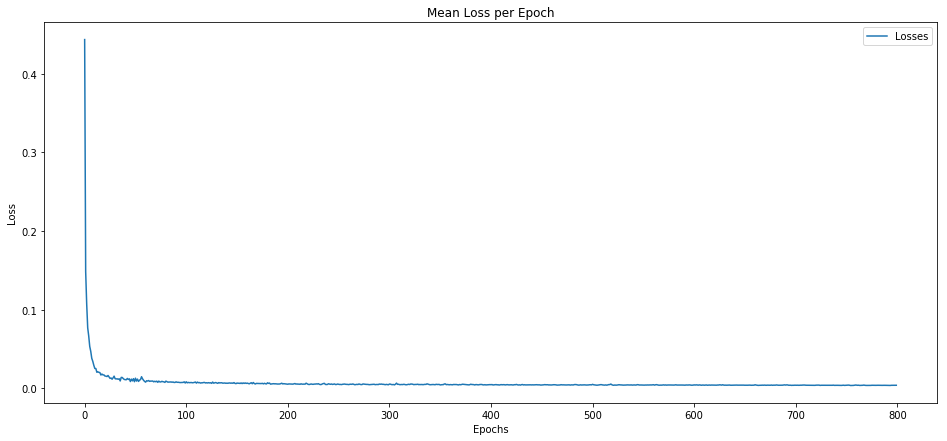

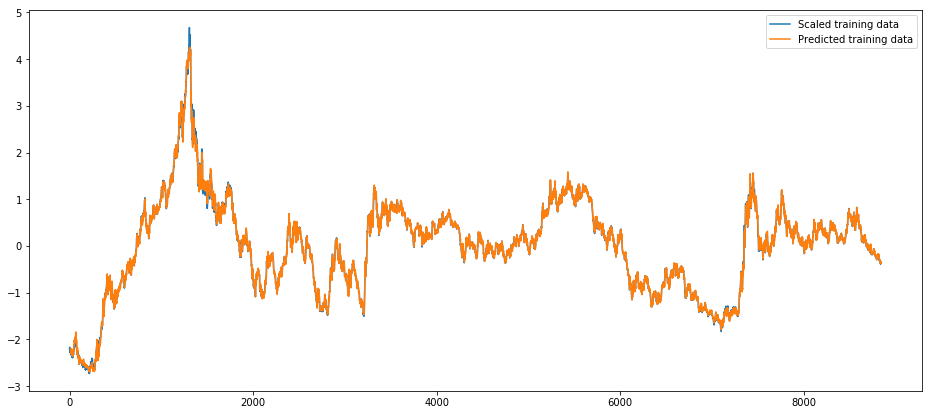

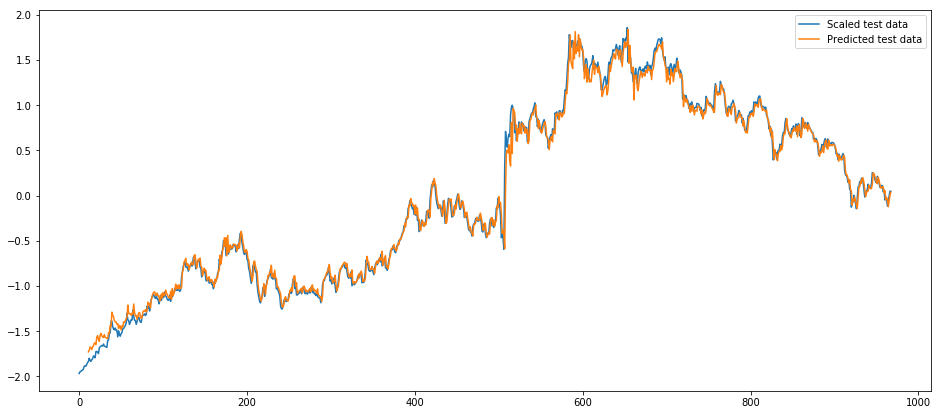

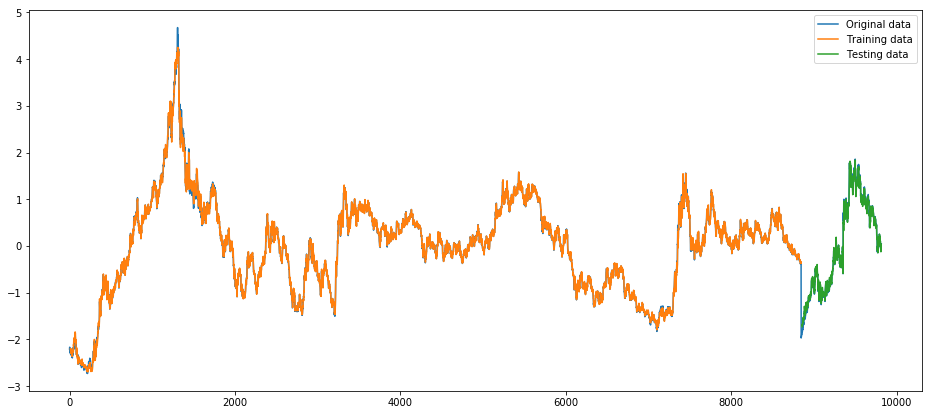

The training error is:  [0.00301879] . The testing error is:  [0.00775585] .
Model  NL2_SL16_DRI1_PL2_L1Lam0_L2Lam0.002_EP800  starts running.
Tensor("strided_slice:0", shape=(11, 16), dtype=float32)
Epoch 0/800  Current loss: 0.45964691042900085
Epoch 50/800  Current loss: 0.008027047850191593
Epoch 100/800  Current loss: 0.009703638963401318
Epoch 150/800  Current loss: 0.007411720231175423
Epoch 200/800  Current loss: 0.005964376963675022
Epoch 250/800  Current loss: 0.005645617377012968
Epoch 300/800  Current loss: 0.0052895862609148026
Epoch 350/800  Current loss: 0.005448915529996157
Epoch 400/800  Current loss: 0.005480498541146517
Epoch 450/800  Current loss: 0.005006198771297932
Epoch 500/800  Current loss: 0.00473666051402688
Epoch 550/800  Current loss: 0.004751142114400864
Epoch 600/800  Current loss: 0.0046746074222028255
Epoch 650/800  Current loss: 0.004469328559935093
Epoch 700/800  Current loss: 0.0043412125669419765
Epoch 750/800  Current loss: 0.004133647307753563
Tr

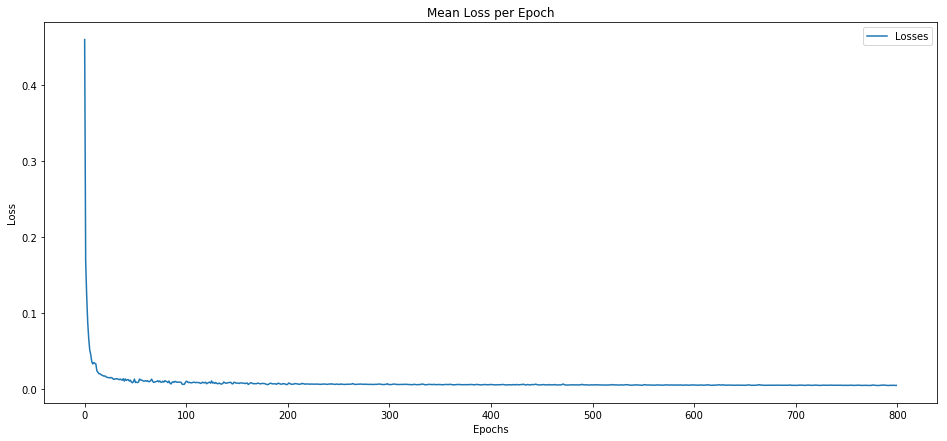

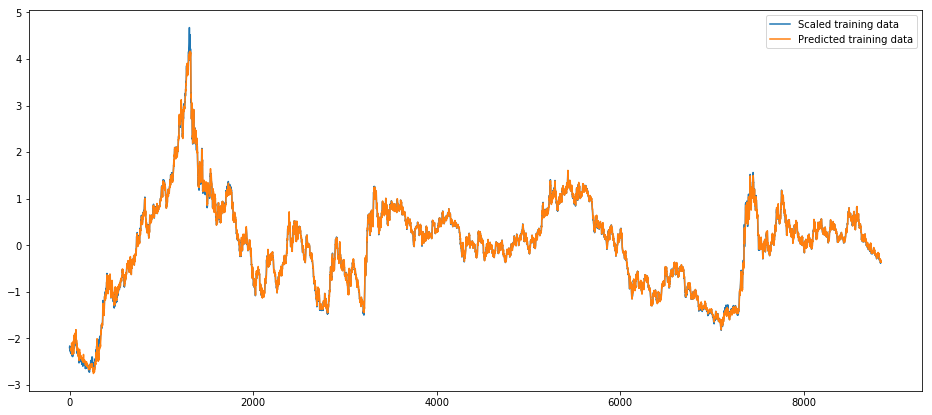

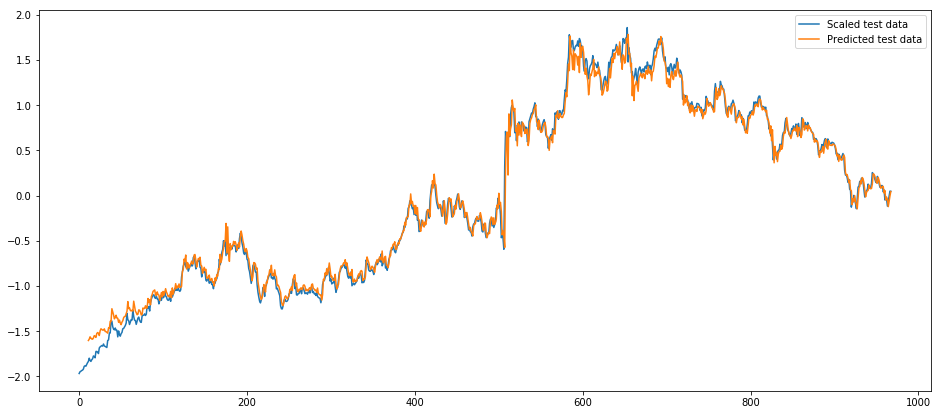

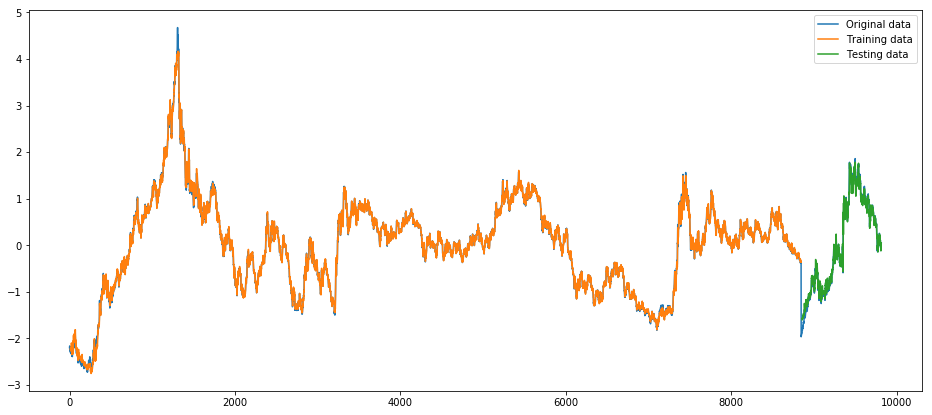

The training error is:  [0.00298045] . The testing error is:  [0.0090934] .
Model  NL2_SL16_DRI1_PL1L2_L1Lam0.0005_L2Lam0.0005_EP800  starts running.
Tensor("strided_slice:0", shape=(11, 16), dtype=float32)
Epoch 0/800  Current loss: 0.41324353218078613
Epoch 50/800  Current loss: 0.011012365110218525
Epoch 100/800  Current loss: 0.009952934458851814
Epoch 150/800  Current loss: 0.008653479628264904
Epoch 200/800  Current loss: 0.0075437407940626144
Epoch 250/800  Current loss: 0.0067134639248251915
Epoch 300/800  Current loss: 0.006619177758693695
Epoch 350/800  Current loss: 0.0061251455917954445
Epoch 400/800  Current loss: 0.006147528998553753
Epoch 450/800  Current loss: 0.00631278520449996
Epoch 500/800  Current loss: 0.005628093611449003
Epoch 550/800  Current loss: 0.005473583471029997
Epoch 600/800  Current loss: 0.0054689813405275345
Epoch 650/800  Current loss: 0.00528179295361042
Epoch 700/800  Current loss: 0.005285041406750679
Epoch 750/800  Current loss: 0.00513402093201

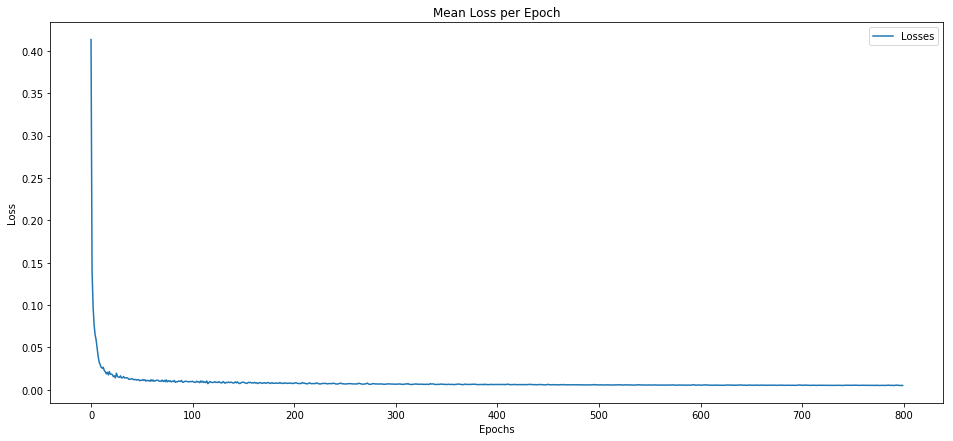

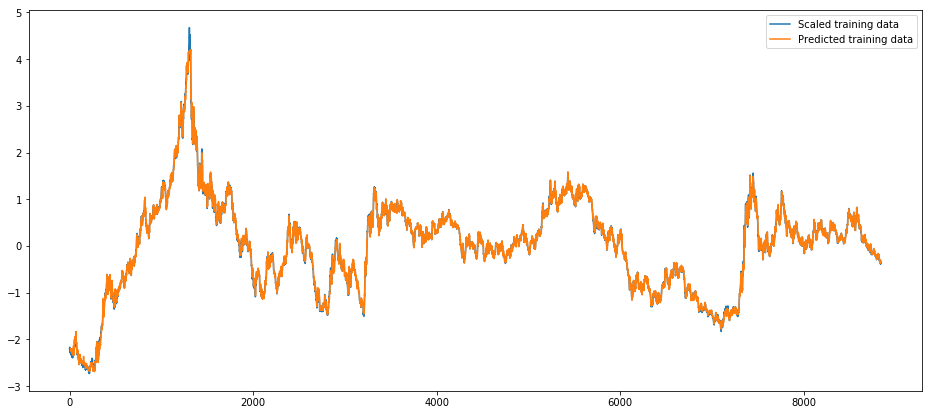

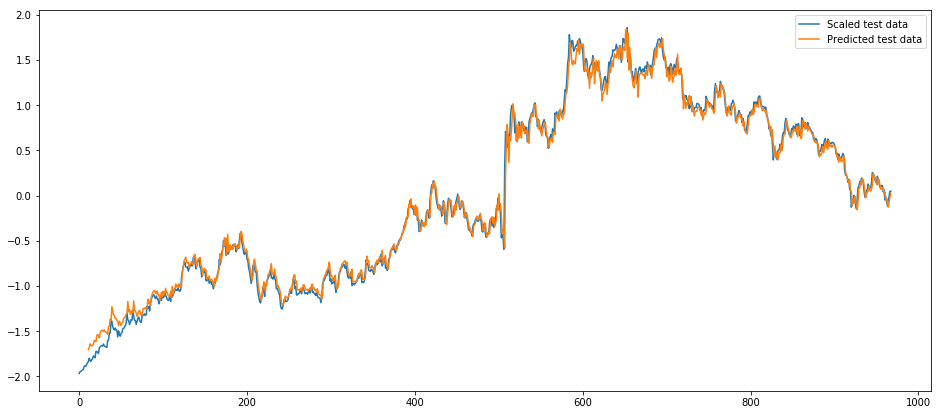

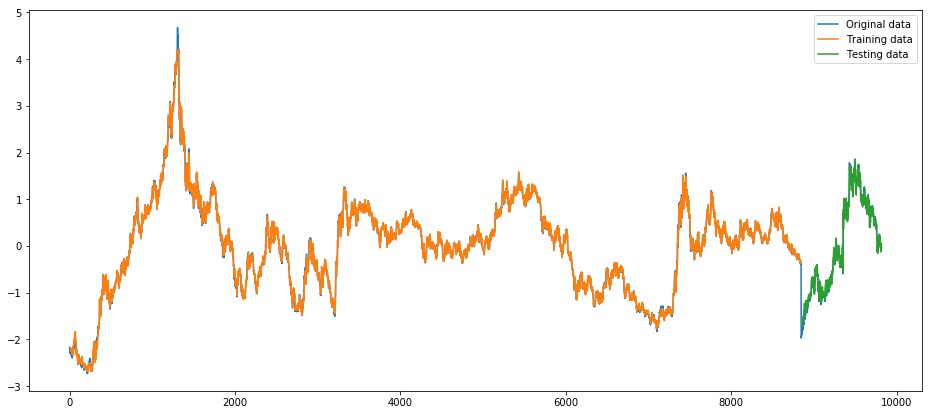

The training error is:  [0.00274643] . The testing error is:  [0.00812314] .
Model  NL2_SL16_DRI1_PL1L2_L1Lam0.0008_L2Lam0.0008_EP800  starts running.
Tensor("strided_slice:0", shape=(11, 16), dtype=float32)
Epoch 0/800  Current loss: 0.4431647062301636
Epoch 50/800  Current loss: 0.013708722777664661
Epoch 100/800  Current loss: 0.010629869997501373
Epoch 150/800  Current loss: 0.008701552636921406
Epoch 200/800  Current loss: 0.008424346335232258
Epoch 250/800  Current loss: 0.007704069837927818
Epoch 300/800  Current loss: 0.007562427315860987
Epoch 350/800  Current loss: 0.007588208187371492
Epoch 400/800  Current loss: 0.007044022437185049
Epoch 450/800  Current loss: 0.007060138043016195
Epoch 500/800  Current loss: 0.0067759365774691105
Epoch 550/800  Current loss: 0.00658967811614275
Epoch 600/800  Current loss: 0.006525584962219
Epoch 650/800  Current loss: 0.006478294264525175
Epoch 700/800  Current loss: 0.006370869465172291
Epoch 750/800  Current loss: 0.006338662933558226


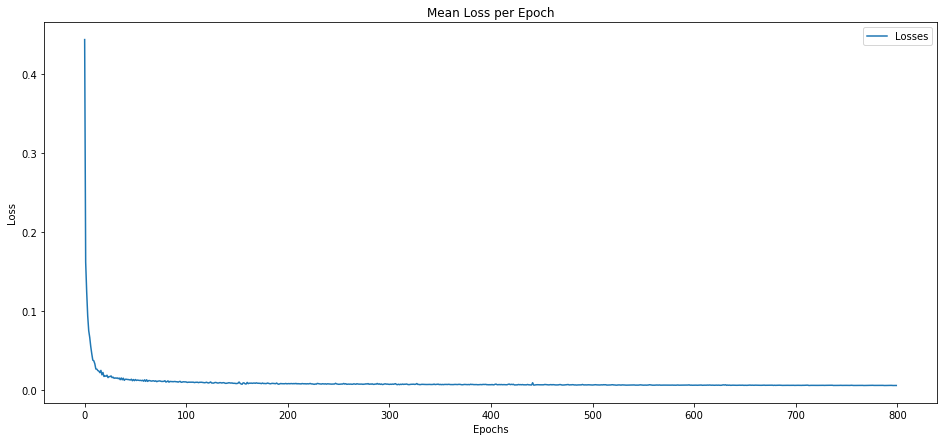

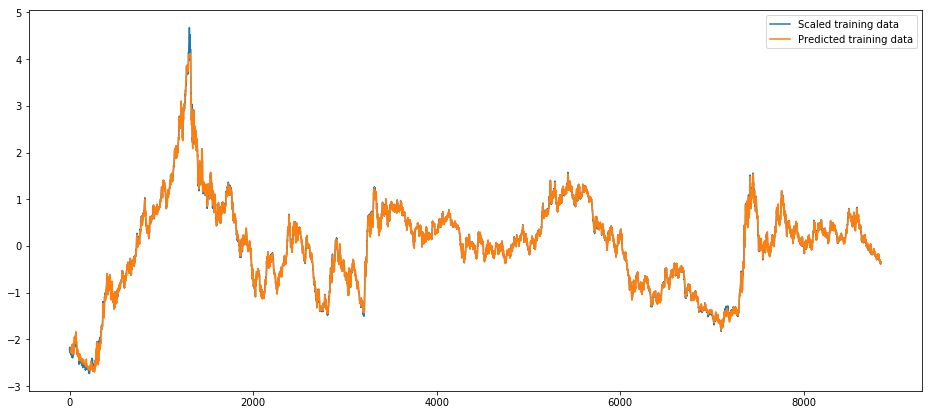

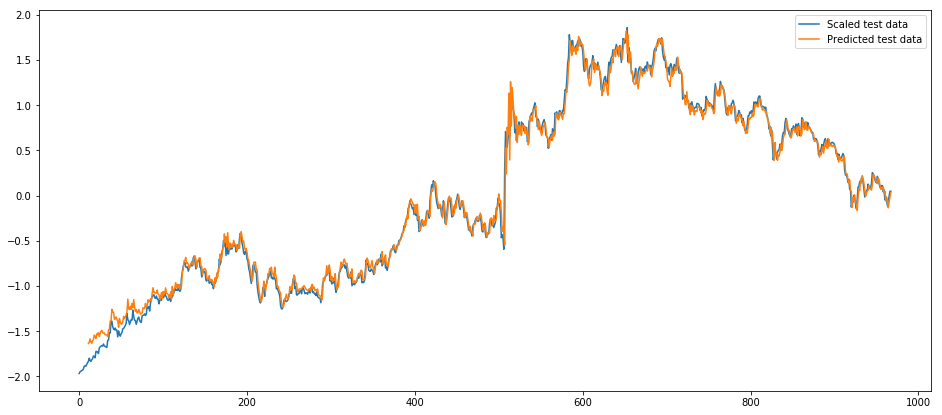

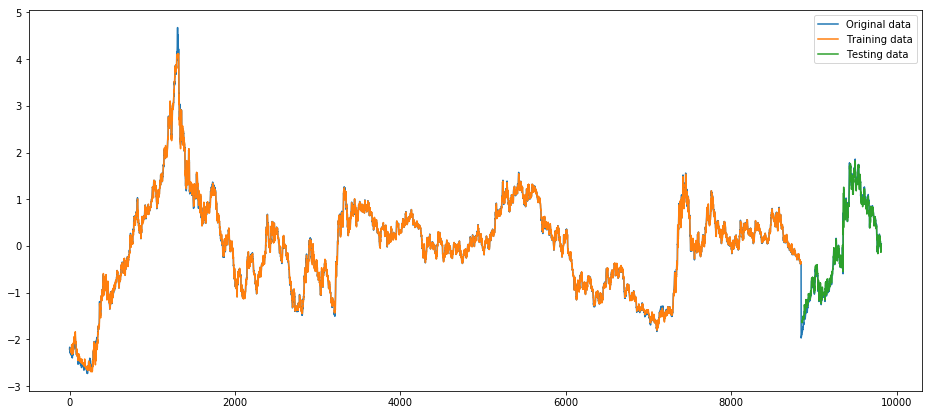

The training error is:  [0.00273962] . The testing error is:  [0.00801282] .
Model  NL4_SL48_DRI1_PL2_L1Lam0_L2Lam0.001_EP1500  starts running.
Tensor("strided_slice:0", shape=(11, 48), dtype=float32)
Epoch 0/1500  Current loss: 0.35700884461402893
Epoch 50/1500  Current loss: 0.024120211601257324
Epoch 100/1500  Current loss: 0.013139497488737106
Epoch 150/1500  Current loss: 0.008405252359807491
Epoch 200/1500  Current loss: 0.008054849691689014
Epoch 250/1500  Current loss: 0.006137719843536615
Epoch 300/1500  Current loss: 0.007202221546322107
Epoch 350/1500  Current loss: 0.005380616988986731
Epoch 400/1500  Current loss: 0.004997031297534704
Epoch 450/1500  Current loss: 0.0042161173187196255
Epoch 500/1500  Current loss: 0.0037888851948082447
Epoch 550/1500  Current loss: 0.004828502424061298
Epoch 600/1500  Current loss: 0.0032748118974268436
Epoch 650/1500  Current loss: 0.0033221361227333546
Epoch 700/1500  Current loss: 0.0034137372858822346
Epoch 750/1500  Current loss: 0.0

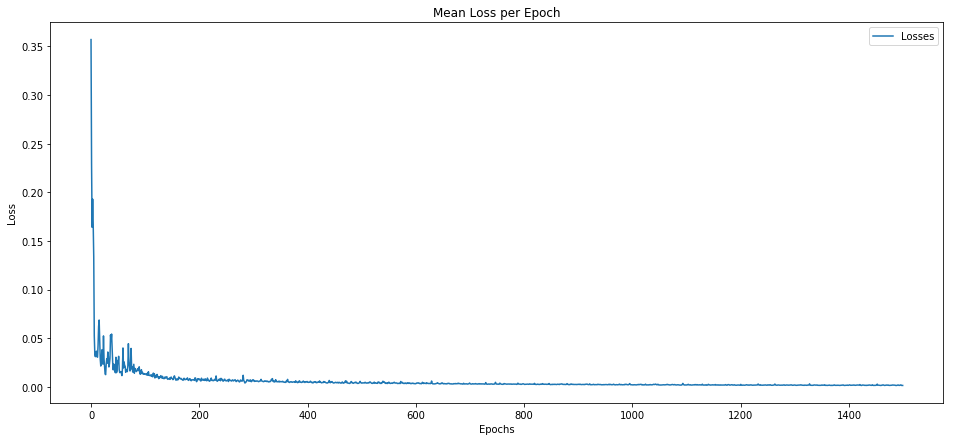

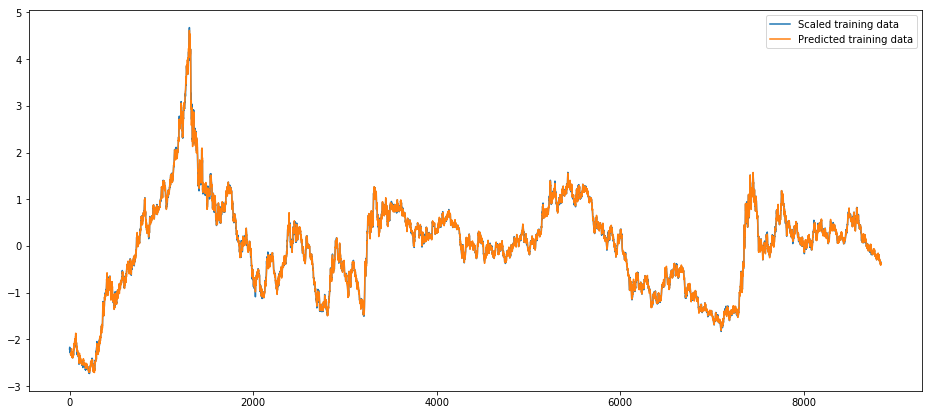

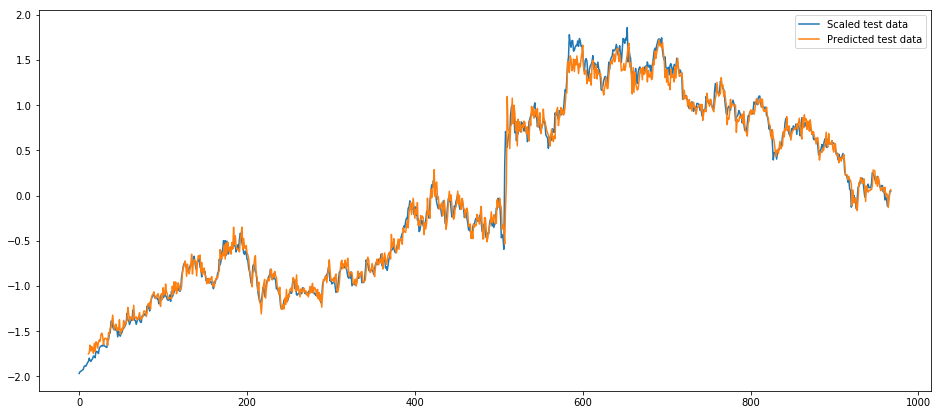

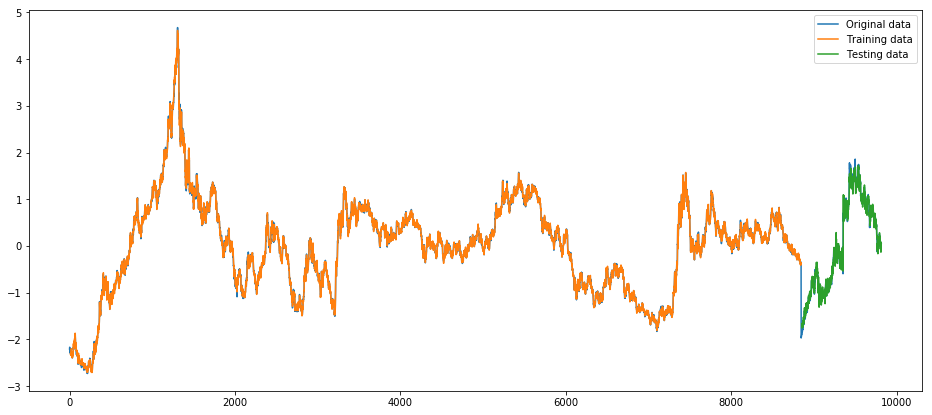

The training error is:  [0.00086393] . The testing error is:  [0.01072516] .
Model  NL4_SL48_DRI1_PL2_L1Lam0_L2Lam0.002_EP1500  starts running.
Tensor("strided_slice:0", shape=(11, 48), dtype=float32)
Epoch 0/1500  Current loss: 0.36377352476119995
Epoch 50/1500  Current loss: 0.020668338984251022
Epoch 100/1500  Current loss: 0.01306393276900053
Epoch 150/1500  Current loss: 0.008540729060769081
Epoch 200/1500  Current loss: 0.007573023904114962
Epoch 250/1500  Current loss: 0.006882249377667904
Epoch 300/1500  Current loss: 0.0050919135101139545
Epoch 350/1500  Current loss: 0.004714834503829479
Epoch 400/1500  Current loss: 0.004958047065883875
Epoch 450/1500  Current loss: 0.004595878999680281
Epoch 500/1500  Current loss: 0.004375011194497347
Epoch 550/1500  Current loss: 0.0034936305601149797
Epoch 600/1500  Current loss: 0.0031948292162269354
Epoch 650/1500  Current loss: 0.002904698019847274
Epoch 700/1500  Current loss: 0.0028410290833562613
Epoch 750/1500  Current loss: 0.002

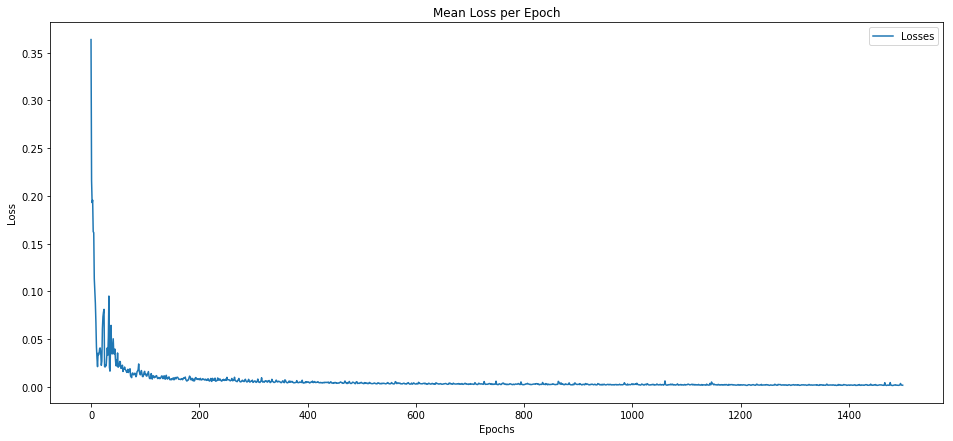

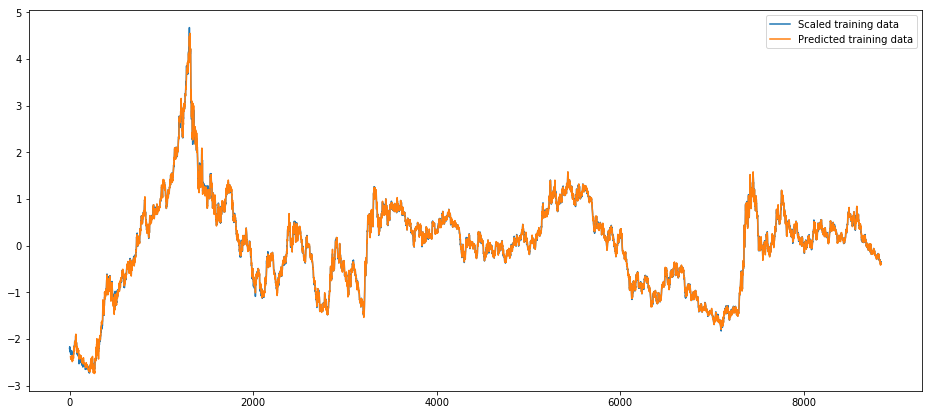

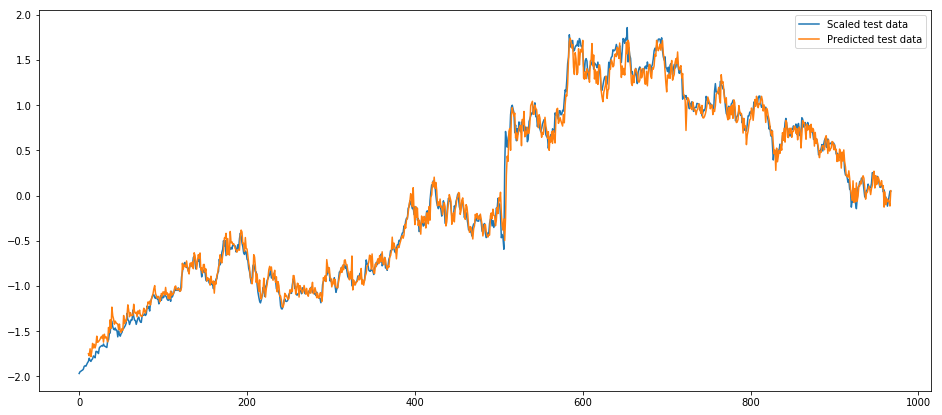

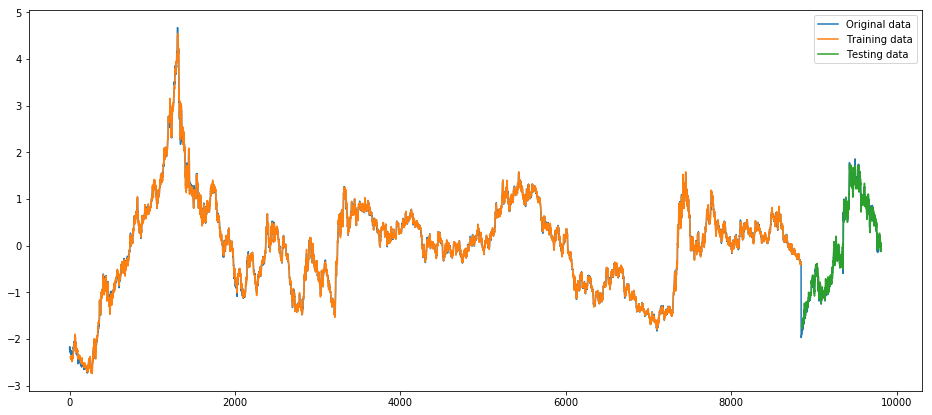

The training error is:  [0.00086622] . The testing error is:  [0.01113454] .
Model  NL4_SL48_DRI1_PL1L2_L1Lam0.0005_L2Lam0.0005_EP1500  starts running.
Tensor("strided_slice:0", shape=(11, 48), dtype=float32)
Epoch 0/1500  Current loss: 0.3584986925125122
Epoch 50/1500  Current loss: 0.019475029781460762
Epoch 100/1500  Current loss: 0.019290532916784286
Epoch 150/1500  Current loss: 0.010151858441531658
Epoch 200/1500  Current loss: 0.008220024406909943
Epoch 250/1500  Current loss: 0.007196672260761261
Epoch 300/1500  Current loss: 0.006659167353063822
Epoch 350/1500  Current loss: 0.007111583836376667
Epoch 400/1500  Current loss: 0.006341858766973019
Epoch 450/1500  Current loss: 0.005800629500299692
Epoch 500/1500  Current loss: 0.006030440330505371
Epoch 550/1500  Current loss: 0.00523145217448473
Epoch 600/1500  Current loss: 0.005501227919012308
Epoch 650/1500  Current loss: 0.004679386969655752
Epoch 700/1500  Current loss: 0.004862879868596792
Epoch 750/1500  Current loss: 0.

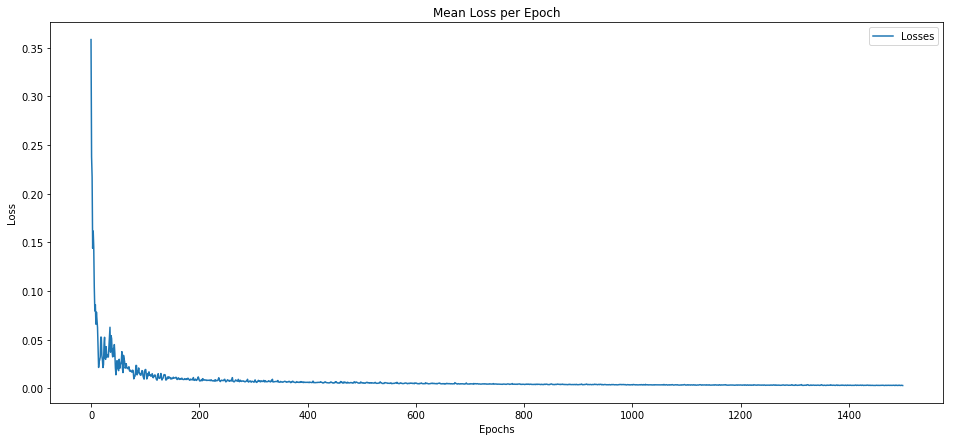

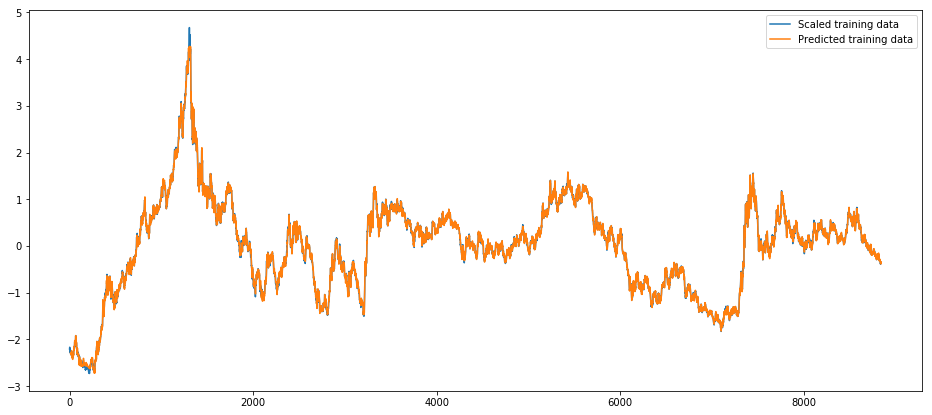

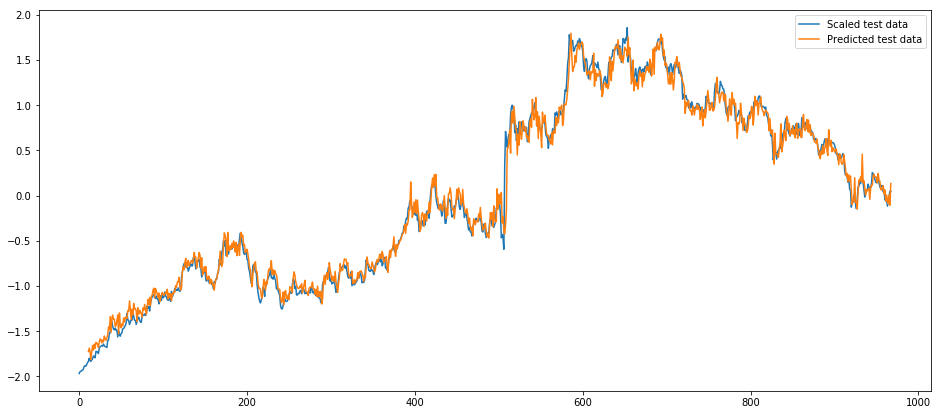

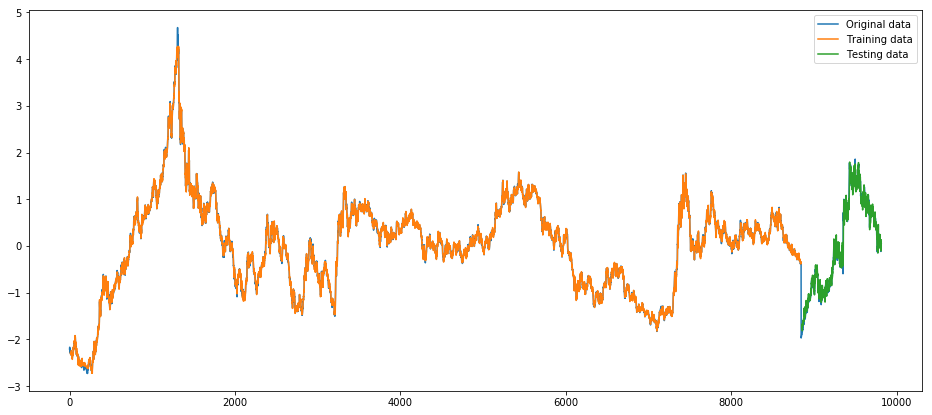

The training error is:  [0.00075426] . The testing error is:  [0.01223089] .
Model  NL4_SL48_DRI1_PL1L2_L1Lam0.0008_L2Lam0.0008_EP1500  starts running.
Tensor("strided_slice:0", shape=(11, 48), dtype=float32)
Epoch 0/1500  Current loss: 0.3637830913066864
Epoch 50/1500  Current loss: 0.026470402255654335
Epoch 100/1500  Current loss: 0.015314358286559582
Epoch 150/1500  Current loss: 0.01813839189708233
Epoch 200/1500  Current loss: 0.01019364781677723
Epoch 250/1500  Current loss: 0.010169832035899162
Epoch 300/1500  Current loss: 0.007980533875524998
Epoch 350/1500  Current loss: 0.008016882464289665
Epoch 400/1500  Current loss: 0.007959168404340744
Epoch 450/1500  Current loss: 0.007142224814742804
Epoch 500/1500  Current loss: 0.006666058674454689
Epoch 550/1500  Current loss: 0.006369722541421652
Epoch 600/1500  Current loss: 0.006156607065349817
Epoch 650/1500  Current loss: 0.005737195257097483
Epoch 700/1500  Current loss: 0.005897151306271553
Epoch 750/1500  Current loss: 0.0

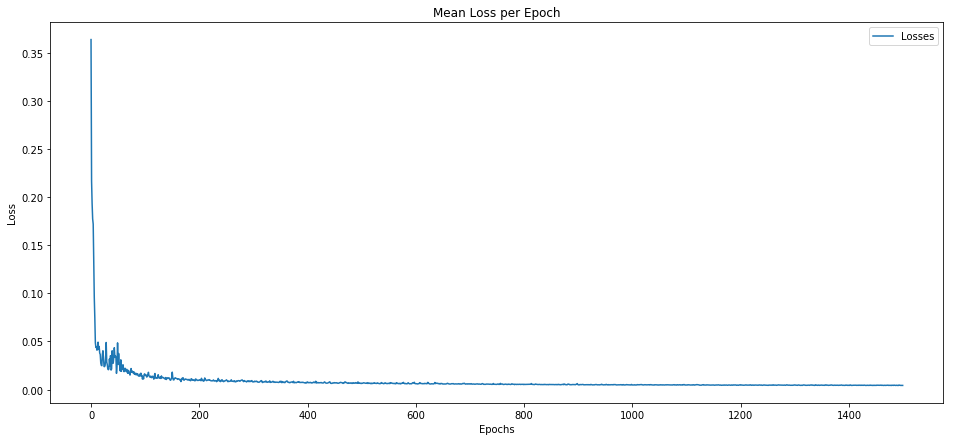

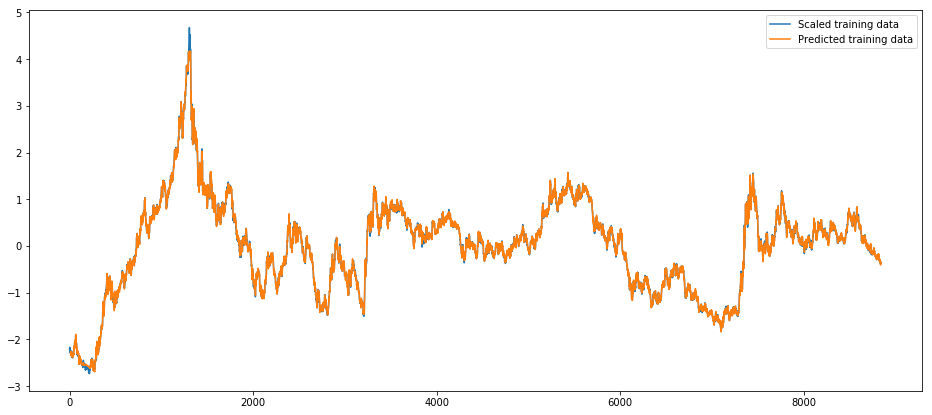

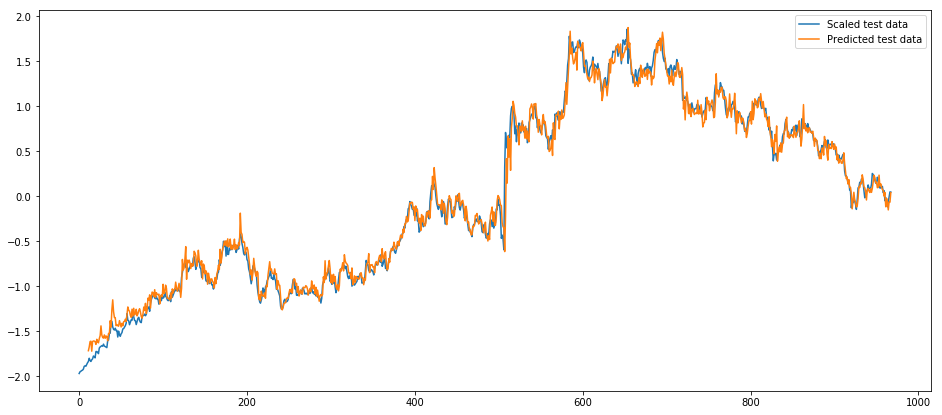

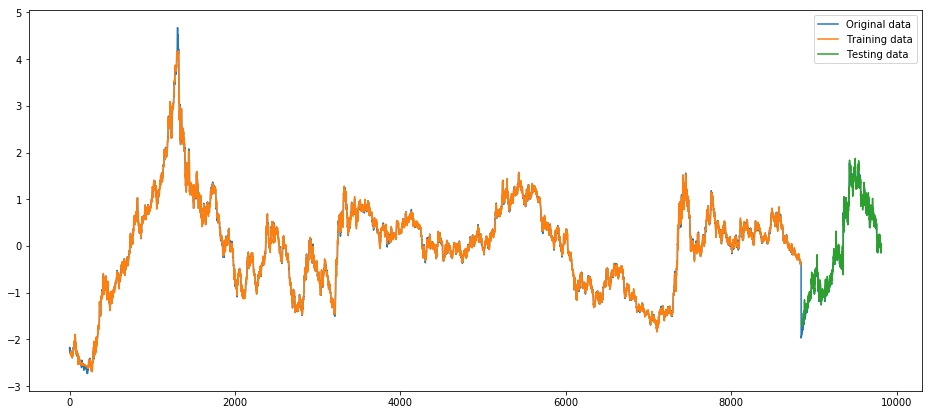

The training error is:  [0.00087961] . The testing error is:  [0.01120076] .


In [23]:
MSE_train_all = []
MSE_test_all = []
Times = []
for l in range(0,len(hidden_num)):
    for m in range(0, len(regs)):
        epochs = epoch[l]
        ModelID = "NL"+str(hidden_num[l])+"_SL"+str(hidden_size[l])+"_DRI"+str(in_keep[m])+"_P"+str(regs[m])+"_L1Lam"+str(l1_lambdas[m])+"_L2Lam"+str(l2_lambdas[m])+"_EP"+str(epochs)
        print("Model ", ModelID, " starts running.")
            
        #Building the model:
        class StockPredictionRNN(object):

            def __init__(self, learning_rate=0.001, batch_size=batch_size, hidden_layer_size=hidden_size[l], number_of_layers=hidden_num[l], 
                         dropout=True, dropout_rate_out=out_keep[m] ,dropout_rate_in=in_keep[m], number_of_classes=1, 
                         gradient_clip_margin=gradient_clip_mrg, window_size=window_size, 
                         l1_l = l1_lambdas[m], l2_l = l2_lambdas[m], l1l2_l1 = l1_lambdas[m], l1l2_l2 = l2_lambdas[m], reg_type = regs[m]):

                self.inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1], name='input_data')
                self.targets = tf.placeholder(tf.float32, [batch_size, 1], name='targets')

                cell, init_state = LSTM_cell(hidden_layer_size, batch_size, number_of_layers, dropout, dropout_rate_out, dropout_rate_in)

                outputs, states = tf.nn.dynamic_rnn(cell, self.inputs, initial_state=init_state)

                self.outputs, self.loss, self.opt = outputlayer_opt_loss(outputs, hidden_layer_size, number_of_classes, self.targets, learning_rate, gradient_clip_margin, l1_l, l2_l, l1l2_l1, l1l2_l2, reg_type)
        tf.reset_default_graph() #resets graph in case there was one before
        model = StockPredictionRNN()
            
        ##TRAINING THE NETWORK:
        session =  tf.Session()
        tf.summary.FileWriter('./OUT', session.graph)
        session.run(tf.global_variables_initializer())
            
        tstart = time.time()
        
        mean_epoch_loss = []
        
        for i in range(epochs):
            traind_scores = []
            ii = 0
            epoch_loss = []
            while(ii + batch_size) <= len(X_train):
                X_batch = X_train[ii:ii+batch_size]
                y_batch = y_train[ii:ii+batch_size]

                o, c, _ = session.run([model.outputs, model.loss, model.opt], feed_dict={model.inputs:X_batch, model.targets:y_batch})

                epoch_loss.append(c)
                traind_scores.append(o)
                ii += batch_size
            if (i % 50) == 0:
                print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))
            mean_epoch_loss.append(np.mean(epoch_loss))
        
        Times.append((time.time()-tstart)/3600)
        print('Training ran for: ', (time.time()-tstart)/3600, ' hours. ModelID: ', ModelID)
            
        ##MEAN LOSSES PER EPOCHS
        plt.figure(figsize=(16, 7))
        plt.plot(mean_epoch_loss, label='Losses')
        plt.title('Mean Loss per Epoch')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig('./OUT/' +ModelID +'_LossPerEpoch.png', format='png', dpi=1000)
        plt.show()
            
        ## Calculating predictions
        ### train
        sup =[]
        for i in range(window_size):
            sup.append(None)
        for i in range(len(traind_scores)):
            for j in range(len(traind_scores[i])):
                sup.append(traind_scores[i][j])
        ### test
        tests = []
        i = 0
        while i + batch_size <= len(X_test):

            o = session.run([model.outputs], 
                            feed_dict={
                                model.inputs:X_test[i:i + batch_size]
                            })
            i += batch_size
            tests.append(o)
            
        tests_new = []
        for i in range(len(tests)):
            for j in range(len(tests[i][0])):
                tests_new.append(tests[i][0][j])
            
        test_results = []
        for i in range(len(data_new)-len(tests_new)):
            test_results.append(None)
        for i in range(len(tests_new)):
            test_results.append(tests_new[i])
            
        ### PLOTTING RESULTS
        plt.figure(figsize=(16, 7))
        plt.plot(train, label='Scaled training data')
        plt.plot(sup, label='Predicted training data')
        plt.legend()
        plt.savefig('./OUT/' + ModelID+'_PRED_train.png', format='png', dpi=1000)
        plt.show()

        plt.figure(figsize=(16, 7))
        plt.plot(test, label='Scaled test data')
        plt.plot(test_results[train_end:], label='Predicted test data')
        plt.legend()
        plt.savefig('./OUT/' + ModelID + '_PRED_test.png', format='png', dpi=1000)
        plt.show()
         
        plt.figure(figsize=(16, 7))
        plt.plot(data_new, label='Original data')
        plt.plot(sup, label='Training data')
        plt.plot(test_results, label='Testing data')
        plt.legend()
        plt.savefig('./OUT/' + ModelID + '_PRED_full.png', format='png', dpi=1000)
        plt.show()    
    
        MSE_test = 0
        MSE_train = 0

        #test
        for n in range(0,len(tests_new)):
            MSE_test += (tests_new[n]-test[n+window_size])**2

        #train
        for n in range(window_size, len(train)):
            MSE_train += (sup[n]-train[n])**2

        MSE_test = MSE_test/len(tests_new) 
        MSE_train = MSE_train/(len(train)-window_size)
        
        MSE_train_all.append(MSE_train)
        MSE_test_all.append(MSE_test)
        print("The training error is: ", MSE_train, ". The testing error is: ", MSE_test, ".")
            
        #Close session
        session.close()
            
#Save html
save_notebook()
time.sleep(3)
current_file = 'TimeSeries Forecast with LSTM-Loop_New-Step2_V3.ipynb'
output_file = './OUT/output_file_'+ str(time.strftime("%Y%m%d_%H_%M", time.gmtime())) + '.html' 
output_HTML(current_file, output_file)
            

The below is to easily copy the errors and runtimes to excel:

In [24]:
import win32clipboard as clipboard

def toClipboardForExcel(array):
    """
    Copies an array into a string format acceptable by Excel.
    Columns separated by \t, rows separated by \n
    """
    # Create string from array
    line_strings = []
    for line in array:
        line_strings.append("\t".join(line.astype(str)).replace("\n",""))
    array_string = "\r\n".join(line_strings)

    # Put string into clipboard (open, clear, set, close)
    clipboard.OpenClipboard()
    clipboard.EmptyClipboard()
    clipboard.SetClipboardText(array_string)
    clipboard.CloseClipboard()

In [ ]:
toClipboardForExcel(MSE_train_all)